# Moment models fine-tune analysis
> This notebook is the pre-analysis of moment models to select the cases used in the paper.

In [1]:
# Input parameters
model_patch_size = 8
verbose          = 0
reset_kernel     = False

In [100]:
#! pip install --no-deps ydata_profiling
#! pip install --no-deps dacite
#! pip install --no-deps multimethod
#! pip install --no-deps visions
#! pip install --no-deps wordcloud
#! pip install --no-deps imagehash
#! pip install --no-deps htmlmin

In [2]:
# Imports
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut
from dvats.imports import beep
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import ydata_profiling as ydp
import seaborn as sns

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(



Octave is ready <oct2py.core.Oct2Py object at 0x7f17e5c9eb60>

















In [4]:
import torch
torch.cuda.set_device(1)

In [5]:
from fastai.losses import MSELossFlat
from dvats.encoder import MAELossFlat, EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE
import dvats.config as cfg_
import gc
import os

### Setting up Weight & Biases information

In [6]:
# User and project
entity = os.environ.get("WANDB_ENTITY")
project = os.environ.get("WANDB_PROJECT")
folder = entity+'/'+project+'/'

# Dataset
dataset = 'gtrends_kohls'
dataset_version = 'v2'
enc_artifact_dataset = folder + dataset + ':' + dataset_version

# Models
model_family = 'zeroshot-moment'
task = 'embedding'
enc_artifact_small_name = folder + model_family + '-small-' + task + ':v0'
enc_artifact_base_name  =  folder + model_family + '-base-' + task + ':v0'
enc_artifact_large_name = folder + model_family + '-large-' + task + ':v0'

### Download dataset

In [7]:
print("Getting dataset artifact: ", enc_artifact_dataset)
df_artifact = wandb_api.artifact(enc_artifact_dataset, type = 'dataset')

Getting dataset artifact:  mi-santamaria/deepvats/gtrends_kohls:v2


In [8]:
print(df_artifact.name)
df = df_artifact.to_df()
display(df.head())
df.shape

gtrends_kohls:v2


wandb:   1 of 1 files downloaded.  


volume
2004-01-01  0.010417
2004-01-08  0.010417
2004-01-15  0.010417
2004-01-22  0.000000
2004-01-29  0.000000

(440, 1)

### Encoder Input

In [9]:
enc_input, _ = SlidingWindow(window_len=17, stride=2, get_y=[])(df)
enc_input.shape

(212, 1, 17)

### Functions

In [10]:
def count_parameters(model):
    #return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

def greater_than(lst, val): 
    return [ x for x in lst if x > val]

In [11]:
def plot_with_multiple_secondary_y(df, primary_vars, secondary_vars, figsize=(12, 6)):
    """
    Plots multiple variables with different scales on primary and secondary y-axes.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - primary_vars (list): Variables to plot on the primary y-axis.
    - secondary_vars (list): Variables to plot on the secondary y-axis.
    - figsize (tuple): Size of the figure.

    Returns:
    - None: Displays the plot.
    """
    ax = df[primary_vars + secondary_vars].plot(
        secondary_y=secondary_vars, figsize=figsize
    )
    ax.set_title("Variables with Primary and Secondary Axes")
    plt.show()

In [12]:
def plot_correlation(profile, figsize=(8, 6)):
    correlation_matrix = profile.corr()
    # Crear el heatmap con seaborn
    plt.figure(figsize = figsize)  # Ajusta el tamaño si es necesario
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title("Correlation Matrix")
    plt.show()

### Common Fine-tune args

In [13]:
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

In [14]:
print(config['batch_size'])
print(config['r'])
print(config['analysis_mode'])

16
0.4
online


In [15]:
common_args = {
    "X": df,
    "stride": 1,
    "batch_size": config['batch_size'],
    "cpu": False,
    "to_numpy": False,
    "time_flag": True,
    "n_windows": None,
    "n_windows_percent": None,
    "shot": True,
    "eval_pre": True,
    "eval_post": True,
    "lr": config['r'], #use enc_run lr,
    "lr_scheduler_flag": False,
    "lr_scheduler_name": "cosine_with_restarts",
    "lr_scheduler_num_warmup_steps": None,
    "window_sizes": None,
    "full_dataset": True,
    "window_sizes_offset": 0.05,
    "windows_min_distance": 0, #int(np.ceil(1.5*enc_input.shape[0]/100)),
    "print_to_path": True,
    "print_path": "./logs.txt",
    "print_mode": "w",
    "use_moment_masks": False,
    "mask_stateful": config['mask_stateful'],
    "mask_future": config['mask_future'],
    "mask_sync": config['mask_sync'],
    "analysis_mode": config['analysis_mode'],
    "use_wandb": config['use_wandb'],
    "norm_by_sample": config['norm_by_sample'],
    "norm_use_single_batch": config['norm_use_single_batch'],
    "show_plot": True,
    "metrics": [EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE],
    "metrics_args": [{'squared': False}, {'squared': True}, {}, {}],
    "metrics_names":["mse", "rmse", "mae", "smape"],
    "metrics_dict": None
}

In [16]:
common_args["windows_min_distance"]

0

### Cases execution function

In [93]:
from momentfm.utils.masking import Masking 

In [165]:
def cases_loop(
    model, 
    n_epochs_list, dataset_percents, maskared_percents, n_sizes_list, summarized = True, do_beep = True, verbose = 1):

    mssg = ut.Mssg(verbose = verbose, level = -1)
    result_columns = ['model_size','n_epochs','dataset_percent','maskared_percent','n_windows', 'time','first_loss','first_mse','first_rmse','first_mae','first_smape', 'last_loss','last_mse','last_rmse','last_mae','last_smape']
    result_columns = result_columns if summarized else result_columns + ['losses','eval_results_pre','eval_results_post']
    results = pd.DataFrame(columns = result_columns)
    
    errors = pd.DataFrame(
        columns = [
            'model_size',
            'n_epochs',
            'dataset_percent',
            'maskared_percent',
            'n_windows',
            'windows',
            'error'
        ]
    )
    model_backup = deepcopy(model)
    i = 0
    for n_epochs in n_epochs_list:
        for dataset_percent in dataset_percents:
            print(dataset_percent)
            for maskared_percent in maskared_percents:
                model.mask_generator = Masking(mask_ratio = maskared_percent)
                for sizes in n_sizes_list:
                    print(f"--> epoch {n_epochs}, dataset_percent {dataset_percent}, mask {maskared_percent}")
                    print(f" sizes {sizes}")
                    print(f"Cuda memmory allocated: {torch.cuda.memory_allocated()}")
                    model_case = deepcopy(model_backup)
                    case = {
                            'model_size': "small",
                            'n_epochs': n_epochs,
                            'dataset_percent': dataset_percent,
                            'maskared_percent': maskared_percent,
                            'n_windows': sizes,
                            'windows': None
                           }
                    result_dict = deepcopy(case)
                    error_dict = deepcopy(case)
                    error = False
                    print(1-dataset_percent)
                    result = fine_tune(
                        enc_learn           = model_case,
                        window_mask_percent = maskared_percent,
                        training_percent    = dataset_percent,
                        validation_percent  = 1-dataset_percent,
                        num_epochs          = n_epochs,
                        n_window_sizes      = sizes,
                        verbose             = 0,
                        register_errors     = True,
                        **common_args    
                    )
                    internal_errors = result[9]
                    if len(result[0]) > 0:
                        result_dict.update({
                            'time'             : result[4],
                            'windows'          : result[8].cpu() if isinstance(result[8], torch.Tensor) else result[8],
                            'first_loss'       : result[0][0][0].cpu().item() if torch.is_tensor(result[0][0][0]) else result[0][0][0],
                            'last_loss'        : result[0][-1][-1].cpu().item() if torch.is_tensor(result[0][-1][-1]) else result[0][-1][-1],
                            'first_mse'        : result[1]['mse'].cpu().item() if torch.is_tensor(result[1]['mse']) else result[1]['mse'],
                            'last_mse'         : result[2]['mse'][-1].cpu().item() if torch.is_tensor(result[2]['mse'][-1]) else result[2]['mse'][-1],
                            'first_rmse'       : result[1]['rmse'].cpu().item() if torch.is_tensor(result[1]['rmse']) else result[1]['rmse'],
                            'last_rmse'        : result[2]['rmse'][-1].cpu().item() if torch.is_tensor(result[2]['rmse'][-1]) else result[2]['rmse'][-1],
                            'first_mae'        : result[1]['mae'].cpu().item() if torch.is_tensor(result[1]['mae']) else result[1]['mae'],
                            'last_mae'         : result[2]['mae'][-1].cpu().item() if torch.is_tensor(result[2]['mae'][-1]) else result[2]['mae'][-1],
                            'first_smape'      : result[1]['smape'].cpu().item() if torch.is_tensor(result[1]['smape']) else result[1]['smape'],
                            'last_smape'       : result[2]['smape'][-1].cpu().item() if torch.is_tensor(result[2]['smape'][-1]) else result[2]['smape'][-1]
                        })
        
                        if not summarized:
                            result_dict.update({
                                'losses'           : [[v.cpu().item() if torch.is_tensor(v) else v for v in loss] for loss in result[0]],
                                'eval_results_pre' : {k: v.cpu().item() if torch.is_tensor(v) else v for k, v in result[1].items()},
                                'eval_results_post': {k: v.cpu().item() if torch.is_tensor(v) else v for k, v in result[2].items()},
                                })  
                        results = pd.concat([results, pd.DataFrame([result_dict])], ignore_index=True)
                    else:
                        print("Failed case")
                        # Attach possible errors
                        internal_errors['model_size'] = case['model_size']
                        internal_errors['n_epochs'] = case['n_epochs']
                        internal_errors['dataset_percent'] = case['dataset_percent']
                        internal_errors['maskared_percent'] = case['maskared_percent']
                        internal_errors['windows'] =  result[8]
                        mssg.print(len(internal_errors))
                        internal_errors['windows'] = [result[8]]*len(internal_errors)
                        errors = pd.concat([errors, internal_errors])
                    if not error: mssg.print_error(f" case {case} | time: {result[4]}")
                    before = torch.cuda.memory_allocated()
                    gc.collect()
                    torch.cuda.empty_cache()
                    if do_beep:
                        beep(1)
                    mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}, mask {maskared_percent}, sizes {sizes} -->")
                if do_beep:
                    beep(2)
                    beep(2)
                mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}, mask {maskared_percent} -->")
            if do_beep:
                beep(3)
                beep(3)
                beep(3)
            mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}-->")
        if do_beep:
            beep(4)
            beep(4)
            beep(4)
            beep(4)
        mssg.print(f"epoch {n_epochs}-->")
    if do_beep:
        beep(1000)
        beep(1000)
        beep(1000)
        beep(1000)
        beep(1000)
    return results, errors

# Analysis

## Defining full reasonable values

The following parameters are modified within the fine-tuning:
- `n_epochs_list` is used to set up the number of epochs used in the training step.
- `dataset_percents` is used to select the percentage of the dataset used for each case fine-tuning.
- `maskared_percents` is used to select the  percentage of the training dataset we want to mask for the model to fill it up.
- `sizes` is used to select the number of window sizes we want to use for the fine-tuning.

In [44]:
n_epochs_list     = [5, 10, 20, 40, 80, 100]
dataset_percents  = [0.25, 0.5, 0.75, 1] #1 No tendría sentido porque sería como hacer lo mismo que con mvp.. entrenar con todo el dataset.
maskared_percents = [0.25, 0.5, 0.75] 
sizes             = [1, 5, 10, 15, 20]
total_cases_small = len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")

Total cases: 360


### Moment-Small
Getting the results for moment small.

#### Download the model

In [45]:
print("Getting small artifact: ", enc_artifact_small_name)
enc_artifact_small = wandb_api.artifact(enc_artifact_small_name, type='learner')
print(enc_artifact_small.name)
moment_small = enc_artifact_small.to_obj()

Getting small artifact:  mi-santamaria/deepvats/zeroshot-moment-small-embedding:v0
zeroshot-moment-small-embedding:v0


wandb: Downloading large artifact zeroshot-moment-small-embedding:v0, 144.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5


In [46]:
already_computed_small = True
results_small = None
errors_small = None
file_errors_small = 'errors_small_24012025_1.csv'
file_results_small = 'results_small_24012025_1.csv'

if already_computed_small:
    results_small = pd.read_csv(file_results_small, index_col=None, header=0)
    errors_small = pd.read_csv(file_errors_small, index_col=None, header=0)
else:
    results_small, errors_small = cases_loop(model = moment_small, n_epochs_list = n_epochs_list, dataset_percents = dataset_percents, maskared_percents = maskared_percents, n_sizes_list = sizes, summarized = True)
    results_small.to_csv(file_results_small, index=False, header=True)
    errors_small.to_csv(file_errors_small, index=False, header=True)
    

Observaciones:
- El número de épocas más pequeño a partir de los 

In [47]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_small)}")
display(errors_small.head())
print(f"Total results: {len(results_small)}")
display(results_small.head())

----- ERRORS -----
Total error cases: 504


Unnamed: 0 model_size  n_epochs  dataset_percent  maskared_percent  \
0           0      small         5             0.25              0.25   
1           0      small         5             0.25              0.25   
2           0      small         5             0.25              0.25   
3           0      small         5             0.25              0.25   
4           0      small         5             0.25              0.25   

   n_windows                                                      error  \
0        NaN  maximum size for tensor at dimension 2 is 4 but size is 8   
1        NaN  maximum size for tensor at dimension 2 is 4 but size is 8   
2        NaN  maximum size for tensor at dimension 2 is 3 but size is 8   
3        NaN  maximum size for tensor at dimension 2 is 4 but size is 8   
4        NaN  maximum size for tensor at dimension 2 is 3 but size is 8   

   window                                              windows  
0       4                   [17, 12, 10, 16, 8, 13, 4, 19, 20]  
1       4            [17, 12, 10, 16, 8, 13, 4, 19, 20, 3, 18]  
2       3            [17, 12, 10, 16, 8, 13, 4, 19, 20, 3, 18]  
3       4  [17, 12, 10, 16, 8, 13, 4, 19, 20, 3, 18, 5, 11, 2]  
4       3  [17, 12, 10, 16, 8, 13, 4, 19, 20, 3, 18, 5, 11, 2]

Total results: 360


Unnamed: 0 model_size  n_epochs  dataset_percent  maskared_percent  \
0           0      small         5             0.25              0.25   
1           1      small         5             0.25              0.25   
2           2      small         5             0.25              0.25   
3           3      small         5             0.25              0.25   
4           4      small         5             0.25              0.25   

   n_windows       time  first_loss  first_mse  first_rmse  first_mae  \
0          1   0.915042    0.001881   0.125969    0.016324   0.099191   
1          5   4.147696    0.001488   0.125969    0.016324   0.099191   
2         10   7.023788    0.001918   0.125969    0.016324   0.099191   
3         15   8.343204    0.002160   0.125969    0.016324   0.099191   
4         20  10.059044    0.001449   0.125969    0.016324   0.099191   

   first_smape  last_loss  last_mse  last_rmse  last_mae  last_smape  \
0     1.437279   0.001533  0.125969   0.016324  0.099191    1.437279   
1     1.437279   0.002377  0.048225   0.002455  0.026265    0.241291   
2     1.437279   0.003422  0.124776   0.016271  0.097664    1.383862   
3     1.437279   0.001531  0.125736   0.016273  0.098855    1.441709   
4     1.437279   0.001007  0.133165   0.018136  0.107117    1.631427   

                                               windows  
0                                                 [17]  
1                                  [17, 12, 10, 16, 8]  
2                   [17, 12, 10, 16, 8, 13, 4, 19, 20]  
3            [17, 12, 10, 16, 8, 13, 4, 19, 20, 3, 18]  
4  [17, 12, 10, 16, 8, 13, 4, 19, 20, 3, 18, 5, 11, 2]

In [29]:
print(1)
beep(100)

1


#### Checking the errors
Checking the error cases to see if they can be fixed within the code for the future

In [48]:
error_small_window_sizes = list(errors_small['window'].drop_duplicates())
error_small_window_sizes

[4, 3, 5, 2]

In [49]:
error_small_mssg =errors_small['error'].astype(str).drop_duplicates()
error_small_mssg

0    maximum size for tensor at dimension 2 is 4 but size is 8
2    maximum size for tensor at dimension 2 is 3 but size is 8
5    maximum size for tensor at dimension 2 is 5 but size is 8
6    maximum size for tensor at dimension 2 is 2 but size is 8
Name: error, dtype: object

We see two failures to check within the failures:
1) Windows do no respect the requested distance between sepparated windows (only one with ne next). TODO: check
2) This dataset needs windows bigger than 4 for MOMENT - Small. => 
    => We need:

   - A minimum and maximum variate allowing to ask for windows sizes inside an interval
   - Control within the windows sizes. If we all like this log table, we can save an unique variate (not saving the windows part) just to check if a window has already failed with this error so it does not execute again.
   - ¿Buen TFG un SQL de gestión de errores para DeepVATS? -> Hablar con Víctor

First valid window:

In [37]:
small_windows = results_small['windows'].drop_duplicates()
print(small_windows.shape)
display(small_windows)

(5,)


0                                                   [17]
1                                    [17, 12, 10, 16, 8]
2                     [17, 12, 10, 16, 8, 13, 4, 19, 20]
3              [17, 12, 10, 16, 8, 13, 4, 19, 20, 3, 18]
4    [17, 12, 10, 16, 8, 13, 4, 19, 20, 3, 18, 5, 11, 2]
Name: windows, dtype: object

In [38]:
filtered_windows = small_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
filtered_windows

0                                       [17]
1                        [8, 10, 12, 16, 17]
2            [8, 10, 12, 13, 16, 17, 19, 20]
3        [8, 10, 12, 13, 16, 17, 18, 19, 20]
4    [8, 10, 11, 12, 13, 16, 17, 18, 19, 20]
Name: windows, dtype: object

In [39]:
filtered_windows = small_windows[small_windows.apply(lambda x: all(i > 5 for i in x))]
filtered_windows = filtered_windows.apply(sorted)
filtered_windows

0                   [17]
1    [8, 10, 12, 16, 17]
Name: windows, dtype: object

A futuros, se observa que, cuando analicemos este dataset, deberemos:
- Usar ventanas mayores que 5, preferiblemente, >= 8.
- Corregir la función de ventanas para que indique en un warning y en una variable el número de ventanas devuelto realmente. Gestionar para que si no se ha devuelto el número de ventanas esperado, se corte el loop ahí en lugar de repetir los mismos expserimentos. 

#### Time analysis

In [50]:
total_time = results_small['time'].sum()
print(f"{total_time} seconds")
print(f"{total_time/60} minutes")
print(f"{total_time/60/60} hours")

46383.94182705879 seconds
773.0656971176466 minutes
12.88442828529411 hours


<Axes: >

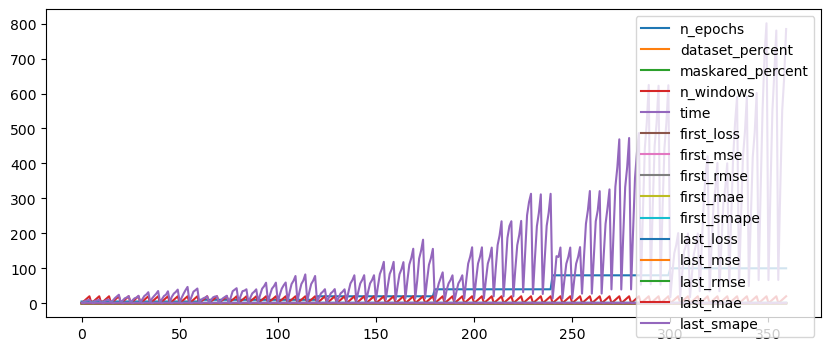

In [41]:
results_small.plot(figsize = (10,4))

<Axes: >

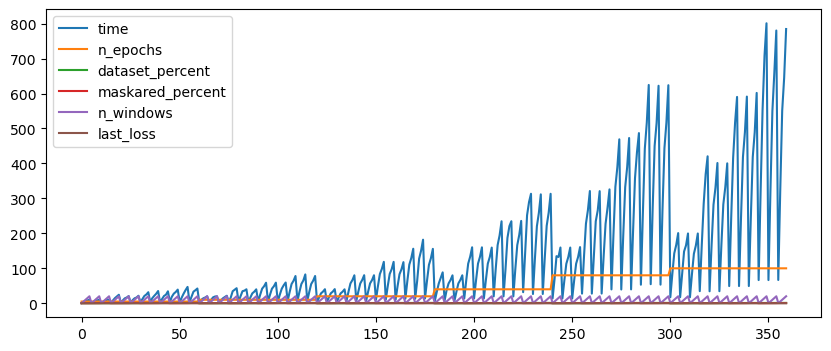

In [124]:
df_time_analysis_small = results_small[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "last_loss"]]
df_time_analysis_small.plot(figsize = (10,4))

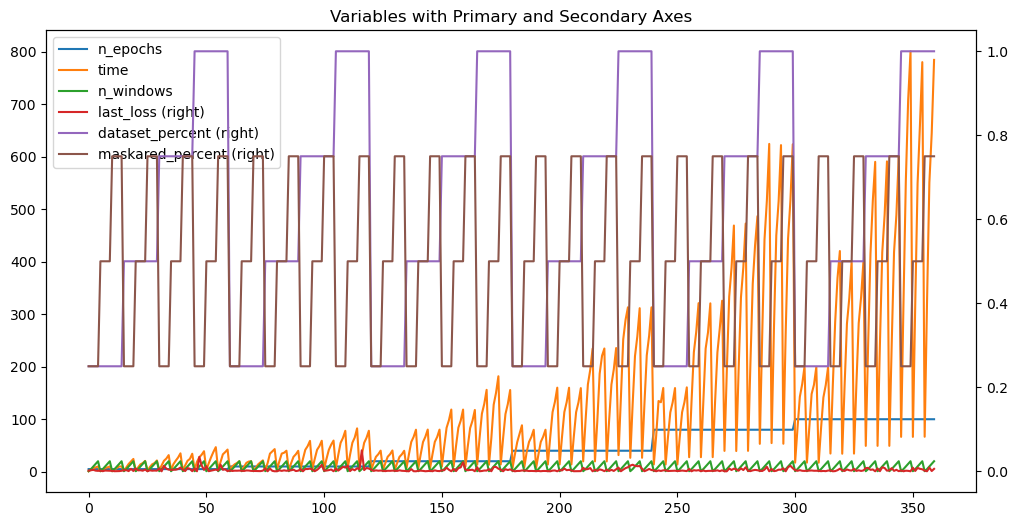

In [125]:
plot_with_multiple_secondary_y(df_time_analysis_small, ["n_epochs", "time", "n_windows"], ["last_loss", "dataset_percent", "maskared_percent"])

In [126]:
profile_small_df = df_time_analysis_small.copy(deep = True)
profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_time_analysis_small'", explorative=True)

In [127]:
#profile_small.to_notebook_iframe()

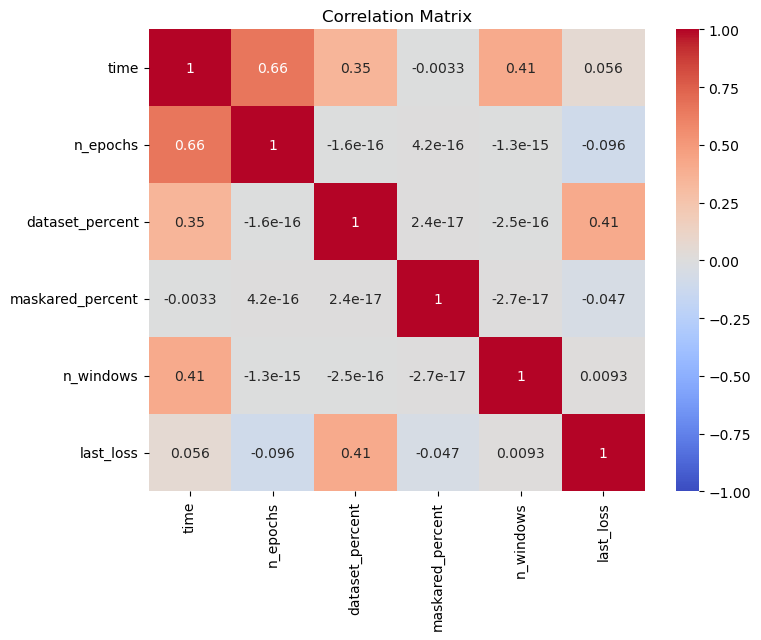

In [128]:
 plot_correlation(profile_small_df)

A nivel de tiempo, se observa que:

- Apenas afecta el enmascarado, con una correlación negativa con el last loss. Lo mismo ocurre con el n_epochs
- Más tiempo parece hacer crecer el last_loss
- Lo que más influye es el porcentaje de dataset utilizado para el fine_tuning. Más dataset parece hacer empeorar por alguna razón
- El last loss está bastante relacionado con el tiempo dedicado al fine-tuning, como es de esperar. Pero. La correlación es positiva => más last loss => más tiempo.
- El número de ventanas parece ir en contra de bajar el loss.. quizá porque va de la mano del número de ventanas.


### Loss & metrics analysis

A nivel de losses, se observa (sin tener en cuenta mse, rmse, mae, smape): 
- Muy poca relación con el enmascarado, cosa que de primeras sorprende
- Mucha relación con el % de dataset utilizado en el fine-tuning
Por lo tanto,
    - vamos a filtrar el dataset para tener tiempos menores a 8 segundos
y buenos losses.
    - Veamos a partir de qué momento se obtienen unos losses razonables  en %.

In [129]:
df_loss_small = results_small[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "first_loss", "last_loss"]].copy()

<Axes: >

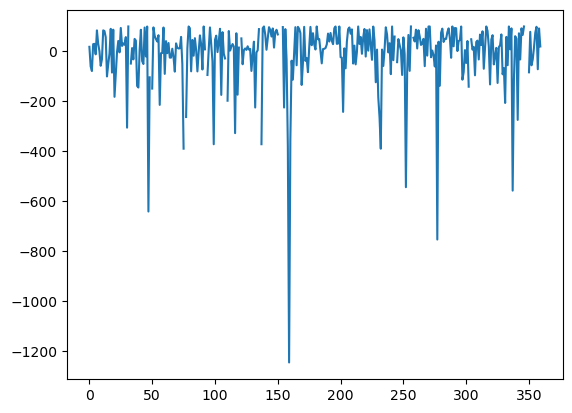

In [130]:
df_loss_small["loss_percent"] = (df_loss_small['first_loss']-df_loss_small['last_loss'])*100/(df_loss_small['first_loss'])
df_loss_small["loss_percent"].plot()

<Axes: >

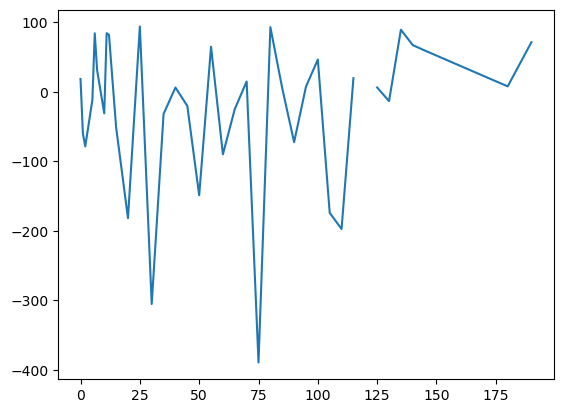

In [131]:
df_loss_small[df_loss_small["time"] < 8]["loss_percent"].plot()

In [132]:
# Filtrar filas donde "time" es menor a 8 segundos
df_loss_small_best_cases = df_loss_small[df_loss_small["time"] < 8].copy()
# Filtrar los 5 mejores loss_percents
display(df_loss_small_best_cases.sort_values('loss_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_small_best_cases[df_loss_small_best_cases['dataset_percent'] < 0.50].sort_values('loss_percent', ascending = False)[:5])

time  n_epochs  dataset_percent  maskared_percent  n_windows  \
25   1.719158         5             0.50              0.75          1   
80   4.210362        10             0.50              0.50          1   
135  6.867298        20             0.50              0.25          1   
11   4.377580         5             0.25              0.75          5   
6    4.191192         5             0.25              0.50          5   

     first_loss  last_loss  loss_percent  
25     0.002114   0.000125     94.092433  
80     0.002906   0.000200     93.111460  
135    0.003436   0.000364     89.417086  
11     0.001210   0.000189     84.410799  
6      0.001702   0.000266     84.352761

time  n_epochs  dataset_percent  maskared_percent  n_windows  \
11   4.377580         5             0.25              0.75          5   
6    4.191192         5             0.25              0.50          5   
12   7.095377         5             0.25              0.75         10   
190  6.932321        40             0.25              0.75          1   
7    7.109320         5             0.25              0.50         10   

     first_loss  last_loss  loss_percent  
11     0.001210   0.000189     84.410799  
6      0.001702   0.000266     84.352761  
12     0.001704   0.000308     81.926578  
190    0.001426   0.000407     71.463528  
7      0.002491   0.001721     30.924853

#### What if I focus on 0.25 dataset percent?

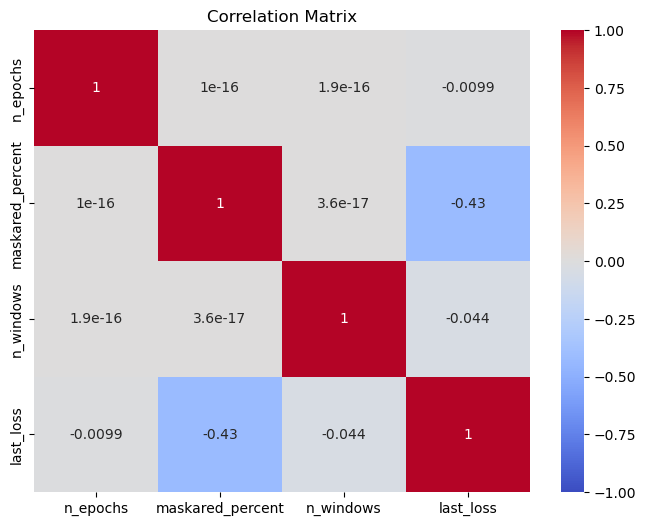

In [138]:
profile_small_df_2 = df_time_analysis_small[df_time_analysis_small['dataset_percent'] == 0.25].drop(columns=['dataset_percent', 'time']).copy()
profile_small_2 = ydp.ProfileReport(profile_small_df_2, title="Pandas Profiling Report for 'df_time_analysis_small' for < 0.25 dataset percent", explorative=True)
plot_correlation(profile_small_df_2)

* Correlación inversa entre maskared percent y last loss * => Aumentar maskared percent baja last_loss
* => Es parte de lo que queremos!

In [67]:
#! ls errors*

In [69]:
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

32818184192
32818184192


In [71]:
before = torch.cuda.memory_allocated()
print(before)
moment_small.to('cpu')
for param in moment_small.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

32818184192
32818184192
Mejorado:  0


## Moment-base

### Download the model

In [95]:
print("Getting base artifact: ", enc_artifact_base_name)
enc_artifact_base  = wandb_api.artifact(enc_artifact_base_name, type='learner')
moment_base  = enc_artifact_base.to_obj()

Getting base artifact:  mi-santamaria/deepvats/zeroshot-moment-base-embedding:v0


wandb: Downloading large artifact zeroshot-moment-base-embedding:v0, 432.97MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3


In [150]:
# Reducimos el número de épocas a los más aparecidos en la tabla de mejores casos
n_epochs_list_base= [5, 10, 20]
#Se pbservçp ima gram reñevamcoa y qie em ñps ,ekpres casps estabam el 0.25 y el 0.5. Fijamos esos.
dataset_percents_base  = [0.25, 0.5]
# El enmascarado influye y el mejor parece esar en 0.5-0.75
maskared_percents_base = [0.1, 0.25, 0.5, 0.75, 0.9]
# No hay correlacion significativa y aumenta mucho los tiempos. Además se observa gran similitud en los tamaños. 
# En a tabla de valores el valor más repetido de manera común entre el genérico y el de 0.25 es 5 y es el valor intermedio.
# Merece la pena fijarse en el 5. Reduciendo solo a los 3 que aparecen 1, 5 y 10 reducimos igualmente d emanera drástica el número de casos.
# Lancemos la experimentación con 1, 5, 10 y analicemos el tiempo, que debería ser bastante menor
sizes_base             = [1,5,10]
total_cases_base = len(n_epochs_list_base)*len(dataset_percents_base)*len(maskared_percents_base)*len(sizes)
print(f"Total cases: {total_cases_base}")
expected_time = total_time*total_cases_base/total_cases_small
print(f"Expected time: {expected_time} seconds | {expected_time/60} minutes | {expected_time/60/60} hours")

Total cases: 90
Expected time: 11595.985456764698 seconds | 193.26642427941164 minutes | 3.2211070713235275 hours


In [137]:
already_computed_base = False
results_base = None
errors_base = None
file_errors_base = 'errors_base_24012025_1.csv'
file_results_base = 'results_base_24012025_1.csv'

In [151]:
results_base = None
errors_base = None
if already_computed_base:
    results_base = pd.read_csv(file_results_base, index_col=None, header=0)
    errors_base = pd.read_csv(file_errors_base, index_col=None, header=0)
else:
    results_base, errors_base = cases_loop(
        model             = moment_base, 
        n_epochs_list     = n_epochs_list_base, 
        dataset_percents  = dataset_percents_base, 
        maskared_percents = maskared_percents_base,
        n_sizes_list      = sizes_base, 
        summarized = True
    )
    results_base.to_csv(file_results_base, index=False, header=True)
    errors_base.to_csv(file_errors_base, index=False, header=True)
    #already_computed_base = True

0.25
--> epoch 5, dataset_percent 0.25, mask 0.1
 sizes 1
Cuda memmory allocated: 6846737920
0.75




















  0% 0/20 [00:00<?, ?it/s]

















  5% 1/20 [00:01<00:20,  1.09s/it]

















 15% 3/20 [00:01<00:05,  3.09it/s]

















 25% 5/20 [00:01<00:02,  5.39it/s]

















 35% 7/20 [00:01<00:01,  7.71it/s]

















 45% 9/20 [00:01<00:01,  9.87it/s]

















 55% 11/20 [00:01<00:00, 11.78it/s]

















 65% 13/20 [00:01<00:00, 13.37it/s]

















 75% 15/20 [00:01<00:00, 14.68it/s]

















 85% 17/20 [00:01<00:00, 15.71it/s]

















100% 20/20 [00:02<00:00,  9.42it/s]


















  0% 0/35 [00:00<?, ?it/s]

















  9% 3/35 [00:00<00:01, 23.83it/s]

















 17% 6/35 [00:00<00:01, 26.82it/s]

















 26% 9/35 [00:00<00:00, 27.85it/s]

















 34% 12/35 [00:00<00:00, 28.50it/s]

















 43% 15/35 [00:00<00:00, 28.82it/s]

















 51% 18/35 [00:00<00:00, 29.03it/s]

















 60% 21/35 [00:00<00:00, 29.20it/s]



















[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.1, 'n_windows': 1, 'windows': None} | time: 1.2205448150634766


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.1, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.1
 sizes 5
Cuda memmory allocated: 7301714432
0.75




















  0% 0/20 [00:00<?, ?it/s]

















  5% 1/20 [00:01<00:20,  1.06s/it]

















 20% 4/20 [00:01<00:03,  4.19it/s]

















 35% 7/20 [00:01<00:01,  7.43it/s]

















 50% 10/20 [00:01<00:00, 10.46it/s]

















 65% 13/20 [00:01<00:00, 13.15it/s]

















 80% 16/20 [00:01<00:00, 15.40it/s]

















100% 20/20 [00:01<00:00, 10.43it/s]


















  0% 0/35 [00:00<?, ?it/s]

















  9% 3/35 [00:00<00:01, 29.29it/s]

















 17% 6/35 [00:00<00:00, 29.33it/s]

















 26% 9/35 [00:00<00:00, 29.30it/s]

















 34% 12/35 [00:00<00:00, 29.34it/s]

















 43% 15/35 [00:00<00:00, 29.29it/s]

















 51% 18/35 [00:00<00:00, 29.34it/s]

















 60% 21/35 [00:00<00:00, 29.39it/s]

















 69% 24/35 [00:00<00:00, 29.37it/s]

















 77% 27/35 [00:00<00:00, 29.10it/s]

















 86% 30/35 [00:01<00:00, 29.08it/s]

















0.13309208239432482
0.01773329725228071
0.10612359096198277
1.7535192636746892




















  0% 0/35 [00:00<?, ?it/s]

















 11% 4/35 [00:00<00:01, 30.34it/s]

















 23% 8/35 [00:00<00:00, 30.52it/s]

















 34% 12/35 [00:00<00:00, 30.63it/s]

















 46% 16/35 [00:00<00:00, 30.63it/s]

















 57% 20/35 [00:00<00:00, 30.55it/s]

















 69% 24/35 [00:00<00:00, 30.63it/s]

















 80% 28/35 [00:00<00:00, 30.73it/s]

















100% 35/35 [00:01<00:00, 30.61it/s]


















  0% 0/21 [00:00<?, ?it/s]

















  5% 1/21 [00:01<00:21,  1.06s/it]

















 19% 4/21 [00:01<00:03,  4.27it/s]

















 33% 7/21 [00:01<00:01,  7.66it/s]

















 48% 10/21 [00:01<00:01, 10.90it/s]

















 62% 13/21 [00:01<00:00, 13.81it/s]

















 76% 16/21 [00:01<00:00, 16.30it/s]

















100% 21/21 [00:01<00:00, 11.17it/s]


0.13459240946138293
0.018132229643628945
0.10738489008035497
1.7784392798955047




















  0% 0/35 [00:00<?, ?it/s]

















  9% 3/35 [00:00<00:01, 29.18it/s]

















 17% 6/35 [00:00<00:00, 29.19it/s]

















 26% 9/35 [00:00<00:00, 29.17it/s]

















 34% 12/35 [00:00<00:00, 29.18it/s]

















 43% 15/35 [00:00<00:00, 29.13it/s]

















 51% 18/35 [00:00<00:00, 29.23it/s]

















 60% 21/35 [00:00<00:00, 29.27it/s]

















 69% 24/35 [00:00<00:00, 29.24it/s]

















 77% 27/35 [00:00<00:00, 29.21it/s]

















 86% 30/35 [00:01<00:00, 29.15it/s]

















100% 35/35 [00:01<00:00, 29.17it/s]


















  0% 0/20 [00:00<?, ?it/s]

















  5% 1/20 [00:01<00:19,  1.05s/it]

















 20% 4/20 [00:01<00:03,  4.37it/s]

















 35% 7/20 [00:01<00:01,  7.96it/s]

















 50% 10/20 [00:01<00:00, 11.48it/s]

















 65% 13/20 [00:01<00:00, 14.76it/s]

















 80% 16/20 [00:01<00:00, 17.63it/s]

















0.05849071973658805
0.0034744225941384845
0.03234666034108141
0.27443481920737767




















  0% 0/35 [00:00<?, ?it/s]

















 11% 4/35 [00:00<00:01, 30.78it/s]

















 23% 8/35 [00:00<00:00, 30.60it/s]

















 34% 12/35 [00:00<00:00, 27.84it/s]

















 43% 15/35 [00:00<00:00, 26.78it/s]

















 51% 18/35 [00:00<00:00, 26.20it/s]

















 60% 21/35 [00:00<00:00, 25.83it/s]

















 69% 24/35 [00:00<00:00, 25.53it/s]

















 77% 27/35 [00:01<00:00, 25.41it/s]

















 86% 30/35 [00:01<00:00, 25.23it/s]

















100% 35/35 [00:01<00:00, 26.04it/s]


















  0% 0/21 [00:00<?, ?it/s]

















  5% 1/21 [00:01<00:20,  1.05s/it]

















 24% 5/21 [00:01<00:02,  5.49it/s]

















 43% 9/21 [00:01<00:01, 10.10it/s]

















 62% 13/21 [00:01<00:00, 14.49it/s]

















 81% 17/21 [00:01<00:00, 18.45it/s]

















100% 21/21 [00:01<00:00, 12.65it/s]


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.1, 'n_windows': 5, 'windows': None} | time: 6.313305616378784


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.1, sizes 5 -->
--> epoch 5, dataset_percent 0.25, mask 0.1
 sizes 10
Cuda memmory allocated: 7301714432
0.75




















  0% 0/20 [00:00<?, ?it/s]

















  5% 1/20 [00:01<00:20,  1.06s/it]

















 20% 4/20 [00:01<00:03,  4.18it/s]

















 35% 7/20 [00:01<00:01,  7.39it/s]

















 50% 10/20 [00:01<00:00, 10.37it/s]

















 65% 13/20 [00:01<00:00, 13.00it/s]

















 80% 16/20 [00:01<00:00, 15.20it/s]

















100% 20/20 [00:01<00:00, 10.34it/s]


















  0% 0/35 [00:00<?, ?it/s]

















  9% 3/35 [00:00<00:01, 28.18it/s]

















 17% 6/35 [00:00<00:01, 28.37it/s]

















 26% 9/35 [00:00<00:00, 28.39it/s]

















 34% 12/35 [00:00<00:00, 28.28it/s]

















 43% 15/35 [00:00<00:00, 28.30it/s]

















 51% 18/35 [00:00<00:00, 27.98it/s]

















 60% 21/35 [00:00<00:00, 28.08it/s]

















 69% 24/35 [00:00<00:00, 28.05it/s]

















 77% 27/35 [00:00<00:00, 27.99it/s]

















 86% 30/35 [00:01<00:00, 28.08it/s]

















0.13113601983027734
0.017212253427781557
0.10393743810870022
1.7210685652567455




















  0% 0/35 [00:00<?, ?it/s]

















  9% 3/35 [00:00<00:01, 24.80it/s]

















 17% 6/35 [00:00<00:01, 24.91it/s]

















 26% 9/35 [00:00<00:01, 24.76it/s]

















 34% 12/35 [00:00<00:00, 24.89it/s]

















 43% 15/35 [00:00<00:00, 24.77it/s]

















 51% 18/35 [00:00<00:00, 24.86it/s]

















 60% 21/35 [00:00<00:00, 24.96it/s]

















 69% 24/35 [00:00<00:00, 24.97it/s]

















 77% 27/35 [00:01<00:00, 24.93it/s]

















 86% 30/35 [00:01<00:00, 24.94it/s]

















100% 35/35 [00:01<00:00, 24.87it/s]


















  0% 0/21 [00:00<?, ?it/s]

















  5% 1/21 [00:01<00:21,  1.07s/it]

















 14% 3/21 [00:01<00:05,  3.18it/s]

















 24% 5/21 [00:01<00:02,  5.59it/s]

















 33% 7/21 [00:01<00:01,  8.03it/s]

















 43% 9/21 [00:01<00:01, 10.34it/s]

















 52% 11/21 [00:01<00:00, 12.43it/s]



















0.13427822599354192
0.018045196960637132
0.10706398035647051
1.791327619320492




















  0% 0/35 [00:00<?, ?it/s]

















  9% 3/35 [00:00<00:01, 23.91it/s]

















 17% 6/35 [00:00<00:01, 23.91it/s]

















 26% 9/35 [00:00<00:01, 23.95it/s]

















 34% 12/35 [00:00<00:00, 23.99it/s]

















 43% 15/35 [00:00<00:00, 23.93it/s]

















 51% 18/35 [00:00<00:00, 23.91it/s]

















 60% 21/35 [00:00<00:00, 23.93it/s]

















 69% 24/35 [00:01<00:00, 23.91it/s]

















 77% 27/35 [00:01<00:00, 23.96it/s]

















 86% 30/35 [00:01<00:00, 23.83it/s]

















100% 35/35 [00:01<00:00, 23.89it/s]


















  0% 0/20 [00:00<?, ?it/s]

















  5% 1/20 [00:01<00:20,  1.06s/it]

















 20% 4/20 [00:01<00:03,  4.24it/s]

















 35% 7/20 [00:01<00:01,  7.52it/s]

















 50% 10/20 [00:01<00:00, 10.59it/s]

















 65% 13/20 [00:01<00:00, 13.34it/s]

















 80% 16/20 [00:01<00:00, 15.60it/s]

















0.058457155374639976
0.0034570256380261535
0.03194547738110994
0.27464875422839086




















  0% 0/35 [00:00<?, ?it/s]

















  9% 3/35 [00:00<00:01, 24.30it/s]

















 17% 6/35 [00:00<00:01, 24.58it/s]

















 26% 9/35 [00:00<00:01, 24.45it/s]

















 34% 12/35 [00:00<00:00, 24.61it/s]

















 43% 15/35 [00:00<00:00, 24.74it/s]

















 51% 18/35 [00:00<00:00, 24.85it/s]

















 60% 21/35 [00:00<00:00, 24.91it/s]

















 69% 24/35 [00:00<00:00, 24.90it/s]

















 77% 27/35 [00:01<00:00, 24.92it/s]

















 86% 30/35 [00:01<00:00, 24.93it/s]

















100% 35/35 [00:01<00:00, 24.82it/s]


















  0% 0/21 [00:00<?, ?it/s]

















  5% 1/21 [00:01<00:21,  1.05s/it]

















 19% 4/21 [00:01<00:03,  4.34it/s]

















 33% 7/21 [00:01<00:01,  7.87it/s]

















 48% 10/21 [00:01<00:00, 11.33it/s]

















 62% 13/21 [00:01<00:00, 14.47it/s]

















 76% 16/21 [00:01<00:00, 17.24it/s]

















0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683




















  0% 0/35 [00:00<?, ?it/s]

















  9% 3/35 [00:00<00:01, 24.99it/s]

















 17% 6/35 [00:00<00:01, 24.98it/s]

















 26% 9/35 [00:00<00:01, 25.02it/s]

















 34% 12/35 [00:00<00:00, 25.08it/s]

















 43% 15/35 [00:00<00:00, 25.06it/s]

















 51% 18/35 [00:00<00:00, 25.06it/s]

















 60% 21/35 [00:00<00:00, 25.09it/s]

















 69% 24/35 [00:00<00:00, 25.03it/s]

















 77% 27/35 [00:01<00:00, 25.04it/s]

















 86% 30/35 [00:01<00:00, 25.03it/s]

















100% 35/35 [00:01<00:00, 25.01it/s]


















  0% 0/21 [00:00<?, ?it/s]

















  5% 1/21 [00:01<00:21,  1.07s/it]

















 14% 3/21 [00:01<00:05,  3.17it/s]

















 24% 5/21 [00:01<00:02,  5.55it/s]

















 33% 7/21 [00:01<00:01,  7.94it/s]

















 43% 9/21 [00:01<00:01, 10.19it/s]

















 52% 11/21 [00:01<00:00, 12.20it/s]



















0.13424750515374168
0.018029564485934648
0.10630007724889647
1.732374839801981




















  0% 0/35 [00:00<?, ?it/s]

















 14% 5/35 [00:00<00:00, 42.02it/s]

















 29% 10/35 [00:00<00:00, 41.80it/s]

















 43% 15/35 [00:00<00:00, 41.81it/s]

















 57% 20/35 [00:00<00:00, 41.90it/s]

















 71% 25/35 [00:00<00:00, 44.14it/s]

















 86% 30/35 [00:00<00:00, 45.60it/s]

















100% 35/35 [00:00<00:00, 44.46it/s]


















  0% 0/21 [00:00<?, ?it/s]

window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 29.75it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.44it/s][A


0.12943146060808255
0.016778515437304888
0.10183990213490934
1.6489753787410808





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 23.89it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.82it/s][A


0.12886406210651719
0.016630973457777715
0.10106343606821429
1.6330185801737453
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.1, 'n_windows': 10, 'windows': None} | time: 11.798293828964233


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.1, sizes 10 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.1 -->
--> epoch 5, dataset_percent 0.25, mask 0.25
 sizes 1
Cuda memmory allocated: 7301715968
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.51it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 23.89it/s][A



















 ... (

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 1.4690842628479004


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.25, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.25
 sizes 5
Cuda memmory allocated: 7757216768
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.51it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 23.95it/s][A



















 ... (

0.13260335716231383
0.017596018887309973
0.10539026268647661
1.7389152859936001





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 25.02it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:02<00:00, 10.14it/s][A


0.13151616725487222
0.017319834833851196
0.10550854115987132
1.776859550675852





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 23.96it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.60it/s][A


0.05858246570485802
0.003474321998116733
0.03190013283457123
0.2717852507081141





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 25.04it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.67it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 7.134444952011108


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.25, sizes 5 -->
--> epoch 5, dataset_percent 0.25, mask 0.25
 sizes 10
Cuda memmory allocated: 7757216768
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.45it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 29.24it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (

0.13133825776332425
0.017264612751964864
0.10424402562924355
1.7348518155307835





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.61it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.17it/s][A


0.1338946250085202
0.01794372290441238
0.10716004971142021
1.8079681312093085





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 29.26it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 11.44it/s][A


0.058554951327814866
0.0034590696798296114
0.03173402427331848
0.27410875409398805





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.70it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 12.64it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.68it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.03it/s][A


0.13138865803425342
0.017278762619226097
0.10373269474636514
1.693276660324357





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:00<00:00, 48.90it/s][A



















 ... (more hidden) ...

window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 35/35 [00:00<00:00, 38.40it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.33it/s][A


0.13193565509679384
0.017421900724299662
0.10312244006223019
1.650671764296521





















100% 35/35 [00:01<00:00, 29.97it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.72it/s][A


0.1290189644091278
0.0166672920133664
0.10158481028182002
1.626024583463181
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 9.78529405593872


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.25, sizes 10 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.25 -->
--> epoch 5, dataset_percent 0.25, mask 0.5
 sizes 1
Cuda memmory allocated: 7757218304
0.75





















100% 20/20 [00:01<00:00, 10.56it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 29.29it/s][A



















100% 20/20 [00:01<00:00, 10.57it/s]A


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 1.1990022659301758


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.5, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.5
 sizes 5
Cuda memmory allocated: 8212719104
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.45it/s][A



















100% 35/35 [00:01<00:00, 29.81it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.47it/s][A



















100% 35/35 [00:01<00:00, 31.24it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden

0.13362056019102433
0.017868339220704636
0.10609083917134528
1.74983699351563





















100% 35/35 [00:01<00:00, 31.30it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.20it/s][A


0.13060006062495577
0.0170850747077012
0.1051002218012738
1.7732742631968264





















100% 35/35 [00:01<00:00, 29.99it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 11.44it/s][A


0.058418821148031104
0.0034484346782943914
0.032291224058848864
0.2737706406987909





















100% 35/35 [00:01<00:00, 31.36it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 12.65it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 5.7078588008880615


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.5, sizes 5 -->
--> epoch 5, dataset_percent 0.25, mask 0.5
 sizes 10
Cuda memmory allocated: 8212719104
0.75





















100% 20/20 [00:01<00:00, 10.54it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 29.20it/s][A



















100% 20/20 [00:01<00:00, 10.56it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.73it/

0.13041597557160214
0.017026406052788077
0.10432068565949427
1.7447594912783082






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.74it/s][A



















100% 21/21 [00:01<00:00, 11.29it/s]A

0.13472599789596085
0.018165397546856445
0.10726722908344433
1.8014257305373185






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 29.25it/s][A



















100% 20/20 [00:01<00:00, 11.57it/s]A

0.05876615276405867
0.0034899972673127456
0.0322746277915797
0.2744299740927242






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.82it/s][A



















100% 21/21 [00:01<00:00, 12.77it/s]A

0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.72it/s][A



















100% 21/21 [00:01<00:00, 11.14it/s]A

0.13202858050776942
0.01744637956923625
0.10510009790825368
1.7469940982908874






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:00<00:00, 48.97it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 35/35 [00:00<00:00, 38.41it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.35it/s][A


0.13013430827971728
0.016961205476919566
0.10253803528865034
1.6459814880012928





















100% 35/35 [00:01<00:00, 29.99it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.72it/s][A


0.1299405990099519
0.016907618429969976
0.10269913437411422
1.672118603347974
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 9.7727952003479


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.5, sizes 10 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.5 -->
--> epoch 5, dataset_percent 0.25, mask 0.75
 sizes 1
Cuda memmory allocated: 8212720640
0.75





















100% 20/20 [00:01<00:00, 10.56it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 29.31it/s][A



















100% 20/20 [00:01<00:00, 10.56it/s]A


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 1.198075771331787


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.75, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.75
 sizes 5
Cuda memmory allocated: 8667697152
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.43it/s][A



















100% 35/35 [00:01<00:00, 29.94it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.44it/s][A



















100% 35/35 [00:01<00:00, 31.15it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden

0.13272038922079
0.017626331877156953
0.10591934287761028
1.7727101994124759





















100% 35/35 [00:01<00:00, 31.24it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.18it/s][A


0.13476095281565054
0.018172473011826534
0.10705194348364404
1.7852342566261439





















100% 35/35 [00:01<00:00, 29.90it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 11.45it/s][A


0.05863528192859781
0.0034661390221924467
0.03183649634821253
0.2724809537711198





















100% 35/35 [00:01<00:00, 31.16it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 12.66it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 5.7181501388549805


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.75, sizes 5 -->
--> epoch 5, dataset_percent 0.25, mask 0.75
 sizes 10
Cuda memmory allocated: 8667697152
0.75





















100% 20/20 [00:01<00:00, 10.53it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 29.25it/s][A



















100% 20/20 [00:01<00:00, 10.55it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.64it/

0.1334595874632807
0.017827619986130222
0.10667983322383857
1.7642044799558045






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.69it/s][A



















100% 21/21 [00:01<00:00, 11.27it/s]A

0.13445929370325288
0.018093740795586906
0.10671002584159447
1.7744320180138793






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 29.24it/s][A



















100% 20/20 [00:01<00:00, 11.58it/s]A

0.058993192726797206
0.0035106418853485507
0.03202114453620268
0.27600576875960825






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.71it/s][A



















100% 21/21 [00:01<00:00, 12.75it/s]A

0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 30.66it/s][A



















100% 21/21 [00:01<00:00, 11.14it/s]A

0.13164113644958525
0.017341890016863225
0.10529635480745045
1.7704484538997654






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:00<00:00, 49.03it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 35/35 [00:00<00:00, 38.43it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.33it/s][A


0.12949204833398983
0.016794313613950177
0.10183243289451523
1.6217205546347369





















100% 35/35 [00:01<00:00, 30.00it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.74it/s][A


0.13178346191233137
0.01737863844158894
0.10332631119603222
1.6575480715727984
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 9.780543088912964


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.75, sizes 10 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.75 -->
--> epoch 5, dataset_percent 0.25, mask 0.9
 sizes 1
Cuda memmory allocated: 8667698688
0.75





















100% 20/20 [00:02<00:00,  9.67it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 29.31it/s][A



















100% 20/20 [00:01<00:00, 10.53it/s]A


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.9, 'n_windows': 1, 'windows': None} | time: 1.1982262134552002


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.9, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.9
 sizes 5
Cuda memmory allocated: 9123199488
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.43it/s][A



















100% 35/35 [00:01<00:00, 29.80it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.40it/s][A



















100% 35/35 [00:01<00:00, 31.29it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden

0.1342555725643937
0.018032348663575698
0.10659437993010429
1.771385247277743





















100% 35/35 [00:01<00:00, 27.11it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.16it/s][A


0.1365576863331603
0.01865784944679546
0.10937483410732889
1.8257435163761861





















100% 35/35 [00:01<00:00, 30.00it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 11.44it/s][A


0.05859243219757333
0.003453776622927125
0.03196523399838556
0.2735717753232037





















100% 35/35 [00:01<00:00, 28.63it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.65it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.9, 'n_windows': 5, 'windows': None} | time: 5.984857559204102


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.9, sizes 5 -->
--> epoch 5, dataset_percent 0.25, mask 0.9
 sizes 10
Cuda memmory allocated: 9123199488
0.75





















100% 20/20 [00:02<00:00,  9.63it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 23.95it/s][A



















100% 20/20 [00:02<00:00,  9.63it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...












0.1321417068126068
0.017478475748871215
0.10446052801454947
1.715875952676405






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 24.94it/s][A



















100% 21/21 [00:02<00:00, 10.26it/s]A

0.13459620402935793
0.01812461610075206
0.1068920550701393
1.7735092891400819






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 24.12it/s][A



















100% 20/20 [00:01<00:00, 10.67it/s]A

0.05860424276350061
0.0034667315909504043
0.032132634683767605
0.27548842987474376






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 25.08it/s][A



















100% 21/21 [00:01<00:00, 11.76it/s]A

0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:01<00:00, 24.95it/s][A



















100% 21/21 [00:02<00:00, 10.14it/s]A

0.1315831901549182
0.01733101828031155
0.10465198959795698
1.7295966267088179






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 35/35 [00:00<00:00, 41.78it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 35/35 [00:01<00:00, 30.49it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.40it/s][A


0.12776532900873966
0.016353810672236294
0.09875113420897143
1.5316573504729476





















100% 35/35 [00:01<00:00, 24.42it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.82it/s][A


0.13013109476061097
0.01695092159619007
0.10239664554149144
1.6362998125585413
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.9, 'n_windows': 10, 'windows': None} | time: 11.971463918685913


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.9, sizes 10 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.9 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25-->
0.5
--> epoch 5, dataset_percent 0.5, mask 0.1
 sizes 1
Cuda memmory allocated: 9123201024
0.5





















100% 14/14 [00:01<00:00,  8.00it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.1, 'n_windows': 1, 'windows': None} | time: 2.9278218746185303


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.1, sizes 1 -->
--> epoch 5, dataset_percent 0.5, mask 0.1
 sizes 5
Cuda memmory allocated: 9578701824
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.92it/s][A



















100% 70/70 [00:02<00:00, 24.50it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.93it/s][A



















100% 70/70 [00:02<00:00, 25.55it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden

0.09954334616549272
0.009913612893499341
0.07717078861825127
1.7381821467784278





















100% 70/70 [00:02<00:00, 25.56it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.13it/s][A


0.09602476249586464
0.00923759053153436
0.07531655578210117
1.7789152837206952





















100% 70/70 [00:02<00:00, 24.47it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.64it/s][A


0.04466493261148205
0.0020126625454294305
0.0259843703166433
0.3098032042001769





















100% 70/70 [00:02<00:00, 25.60it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.08it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.1, 'n_windows': 5, 'windows': None} | time: 13.94415545463562


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.1, sizes 5 -->
--> epoch 5, dataset_percent 0.5, mask 0.1
 sizes 10
Cuda memmory allocated: 9578701824
0.5





















100% 14/14 [00:01<00:00,  8.00it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09575734250017699
0.00917942026405161
0.07526094366532825
1.7333447576023084






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 24.94it/s][A

0.09910220335281165
0.009827399565912128
0.07759272076846917
1.8137079869976265






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 23.99it/s][A

0.044563469962245986
0.002012907648011981
0.025624725860794964
0.30669581732388385






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.79it/s][A



















100% 14/14 [00:01<00:00,  9.75it/s]A

0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.66it/s][A



















100% 14/14 [00:01<00:00,  8.76it/s]A

0.09770652253232223
0.009552379632303874
0.07607450999353371
1.743791100762561






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:01<00:00, 48.98it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 70/70 [00:01<00:00, 38.70it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.51it/s][A


0.09725663011408066
0.009473626621307874
0.07579858288491194
1.6800760839318734





















100% 70/70 [00:02<00:00, 29.90it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.73it/s][A


0.09494539771509766
0.00902882900321433
0.07349310271582989
1.6223817388399364
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.1, 'n_windows': 10, 'windows': None} | time: 21.632948875427246


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.1, sizes 10 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.1 -->
--> epoch 5, dataset_percent 0.5, mask 0.25
 sizes 1
Cuda memmory allocated: 9578703360
0.5





















100% 14/14 [00:01<00:00,  8.60it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 2.411039113998413


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.25, sizes 1 -->
--> epoch 5, dataset_percent 0.5, mask 0.25
 sizes 5
Cuda memmory allocated: 10033679872
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.53it/s][A



















100% 70/70 [00:02<00:00, 29.84it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.55it/s][A



















100% 70/70 [00:02<00:00, 31.11it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.02it/s][A


0.10026539131594485
0.010057361468760828
0.07811524623011626
1.7808765799863755





















100% 70/70 [00:02<00:00, 31.21it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.79it/s][A


0.09772021036678277
0.009562631410436437
0.07683464057728276
1.786115195899793





















100% 70/70 [00:02<00:00, 29.85it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.18it/s][A


0.04504580875243468
0.0020490146240520896
0.026253532163417317
0.31259693662189636





















100% 70/70 [00:02<00:00, 31.37it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.67it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 11.426313161849976


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.25, sizes 5 -->
--> epoch 5, dataset_percent 0.5, mask 0.25
 sizes 10
Cuda memmory allocated: 10033679872
0.5





















100% 14/14 [00:01<00:00,  8.57it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09967075528630254
0.009938801824843494
0.07750361708613737
1.7557977375246228






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.44it/s][A



















100% 14/14 [00:01<00:00,  8.84it/s]A

0.09841473012006807
0.009692363968285472
0.07730755034723
1.7952246815425483






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 29.16it/s][A

0.044891391190110014
0.002040860405688867
0.025892002824087247
0.30759906342037313






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.59it/s][A



















100% 14/14 [00:01<00:00,  9.73it/s]A

0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.56it/s][A



















100% 14/14 [00:01<00:00,  8.74it/s]A

0.09677247898891686
0.009372100984790929
0.07557815419107874
1.7290927832473129






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:01<00:00, 49.01it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 70/70 [00:01<00:00, 38.51it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.48it/s][A


0.09479426198287436
0.009002092667512876
0.07402747906708407
1.6591323821851198





















100% 70/70 [00:02<00:00, 29.90it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.72it/s][A


0.09287542985012184
0.008644891987089787
0.07085124822737923
1.553501729070543
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 19.60797381401062


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.25, sizes 10 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.25 -->
--> epoch 5, dataset_percent 0.5, mask 0.5
 sizes 1
Cuda memmory allocated: 10033681408
0.5





















100% 14/14 [00:01<00:00,  8.61it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 2.4097323417663574


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.5, sizes 1 -->
--> epoch 5, dataset_percent 0.5, mask 0.5
 sizes 5
Cuda memmory allocated: 10489182208
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.54it/s][A



















100% 70/70 [00:02<00:00, 29.84it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.55it/s][A



















100% 70/70 [00:02<00:00, 31.17it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.01it/s][A


0.09678170747357186
0.009375082643740455
0.07574086055623384
1.758420389023738





















100% 70/70 [00:02<00:00, 31.31it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.78it/s][A


0.09920140545109182
0.009851643689394046
0.07743635749617628
1.7940777496845968





















100% 70/70 [00:02<00:00, 30.05it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.20it/s][A


0.04466521765850655
0.0020194772830174
0.025985663022710437
0.30919528449698525





















100% 70/70 [00:02<00:00, 31.31it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.68it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 11.40427041053772


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.5, sizes 5 -->
--> epoch 5, dataset_percent 0.5, mask 0.5
 sizes 10
Cuda memmory allocated: 10489182208
0.5





















100% 14/14 [00:01<00:00,  8.60it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.0975463014224121
0.009527153797395507
0.07654069279494267
1.7974867377135564






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.63it/s][A



















100% 14/14 [00:01<00:00,  8.84it/s]A

0.09783107372021951
0.009579447531885749
0.07699589558078943
1.8106608447811645






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 29.30it/s][A

0.04487550256319869
0.0020336212540050364
0.025629461223441022
0.3076076389774194






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.70it/s][A



















100% 14/14 [00:01<00:00,  9.74it/s]A

0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.70it/s][A



















100% 14/14 [00:01<00:00,  8.76it/s]A

0.09744586589662815
0.00950311671465833
0.07568595919903626
1.7211697350624962






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:01<00:00, 49.14it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 70/70 [00:01<00:00, 38.56it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.51it/s][A


0.09792432030147066
0.009601047884896198
0.07566231179484703
1.6652987905830472





















100% 70/70 [00:02<00:00, 30.05it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.74it/s][A


0.09633250685799992
0.00929267495342909
0.07481255004489258
1.6535320655222965
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 19.518115043640137


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.5, sizes 10 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.5 -->
--> epoch 5, dataset_percent 0.5, mask 0.75
 sizes 1
Cuda memmory allocated: 10489183744
0.5





















100% 14/14 [00:01<00:00,  8.59it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 2.40372371673584


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.75, sizes 1 -->
--> epoch 5, dataset_percent 0.5, mask 0.75
 sizes 5
Cuda memmory allocated: 10944684544
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.54it/s][A



















100% 70/70 [00:02<00:00, 29.99it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.53it/s][A



















100% 70/70 [00:02<00:00, 31.23it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.03it/s][A


0.09861294334905935
0.009731715374992614
0.07656552876199288
1.7392763359746406





















100% 70/70 [00:02<00:00, 31.23it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.80it/s][A


0.09842823933441276
0.009695297546652095
0.07735278846568011
1.7911997484725464





















100% 70/70 [00:02<00:00, 30.03it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.19it/s][A


0.04497405152452936
0.0020396335424849154
0.025188068960254415
0.3030366407803039





















100% 70/70 [00:02<00:00, 31.39it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.69it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 11.389286756515503


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.75, sizes 5 -->
--> epoch 5, dataset_percent 0.5, mask 0.75
 sizes 10
Cuda memmory allocated: 10944684544
0.5





















100% 14/14 [00:01<00:00,  8.61it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09733876166303886
0.00948460457628784
0.07621337951789368
1.726488914723592






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.63it/s][A



















100% 14/14 [00:01<00:00,  8.85it/s]A

0.0982440616456696
0.009657821895054037
0.07648533405733271
1.772167905694922






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 29.29it/s][A

0.04514597236365467
0.0020530058511800935
0.025473024411631982
0.30966328042245755






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 28.07it/s][A



















100% 14/14 [00:01<00:00,  9.13it/s]A

0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 24.97it/s][A

0.0970816237019513
0.009434003468187442
0.07567128822249629
1.7396956355455093






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:01<00:00, 47.91it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 70/70 [00:01<00:00, 38.38it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.48it/s][A


0.095987737379294
0.009225931822589859
0.07375367845579332
1.6327126467375424





















100% 70/70 [00:02<00:00, 29.87it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.72it/s][A


0.09589019478257813
0.009207897951912772
0.07412180539816551
1.6324492555812178
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 20.322146892547607


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.75, sizes 10 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.75 -->
--> epoch 5, dataset_percent 0.5, mask 0.9
 sizes 1
Cuda memmory allocated: 10944686080
0.5





















100% 14/14 [00:01<00:00,  8.62it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.9, 'n_windows': 1, 'windows': None} | time: 2.3833258152008057


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.9, sizes 1 -->
--> epoch 5, dataset_percent 0.5, mask 0.9
 sizes 5
Cuda memmory allocated: 11399662592
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.92it/s][A



















100% 70/70 [00:02<00:00, 24.55it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.94it/s][A



















100% 70/70 [00:02<00:00, 25.55it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden

0.09862239971400892
0.009732207394962089
0.07700810455011116
1.7687288345103112





















100% 70/70 [00:02<00:00, 25.58it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.13it/s][A


0.09755091698502819
0.009525735790379413
0.07617323800165914
1.7566377652634775





















100% 70/70 [00:02<00:00, 24.52it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.64it/s][A


0.04481586808619157
0.0020295143812048702
0.025836080656919252
0.30894339856120406





















100% 70/70 [00:02<00:00, 25.61it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.09it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.9, 'n_windows': 5, 'windows': None} | time: 13.927879810333252


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.9, sizes 5 -->
--> epoch 5, dataset_percent 0.5, mask 0.9
 sizes 10
Cuda memmory allocated: 11399662592
0.5





















100% 14/14 [00:01<00:00,  8.01it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.0991188875976494
0.00983237174197782
0.07759251203181008
1.783942475206029






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 24.89it/s][A

0.09868668644125214
0.00975002503245145
0.07659303102089732
1.7469990463139162






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 24.06it/s][A

0.04486641317851736
0.002032927038711497
0.025738558975051645
0.3085238102562363






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 25.01it/s][A

0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 25.03it/s][A

0.09666328270131355
0.00935258462611836
0.07519828785928465
1.6837004508998266






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:01<00:00, 41.98it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 70/70 [00:02<00:00, 30.86it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.87it/s][A


0.09511241036942307
0.009061458666513988
0.07306395452855806
1.6249822652684789





















100% 70/70 [00:02<00:00, 29.85it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.73it/s][A


0.095014754036307
0.009049831352391477
0.07314107533207369
1.5898762312993207
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.9, 'n_windows': 10, 'windows': None} | time: 23.34393620491028


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.9, sizes 10 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.9 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5-->


[1]  [ cases_loop ] epoch 5-->
0.25
--> epoch 10, dataset_percent 0.25, mask 0.1
 sizes 1
Cuda memmory allocated: 11399664128
0.75





















100% 20/20 [00:01<00:00, 10.56it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.1, 'n_windows': 1, 'windows': None} | time: 2.4016411304473877


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.1, sizes 1 -->
--> epoch 10, dataset_percent 0.25, mask 0.1
 sizes 5
Cuda memmory allocated: 11855164928
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.46it/s][A



















100% 70/70 [00:02<00:00, 29.93it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.43it/s][A



















100% 70/70 [00:02<00:00, 31.10it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden

0.13271814106205962
0.017627155237630067
0.10506907678567984
1.7266152670988346





















100% 70/70 [00:02<00:00, 31.30it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.20it/s][A


0.13399141932585382
0.017972352347891442
0.10710675955612836
1.7934742397769305





















100% 70/70 [00:02<00:00, 30.11it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 11.45it/s][A


0.05862099159735454
0.003459638875427936
0.03198755734441743
0.2738840967501448





















100% 70/70 [00:02<00:00, 31.34it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 12.59it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.1, 'n_windows': 5, 'windows': None} | time: 11.396286487579346


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.1, sizes 5 -->
--> epoch 10, dataset_percent 0.25, mask 0.1
 sizes 10
Cuda memmory allocated: 11855164928
0.75





















100% 20/20 [00:01<00:00, 10.54it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.13268356578060028
0.01761899581763503
0.10673688151810674
1.7912119107425122






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.73it/s][A



















100% 21/21 [00:01<00:00, 11.26it/s]A

0.13507808244764924
0.018255778833132723
0.10768704788074912
1.819828419408465






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 29.30it/s][A

0.05867755189479658
0.0034679958662935852
0.03177449608942039
0.2733331453173152






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.76it/s][A



















100% 21/21 [00:01<00:00, 12.75it/s]A

0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.75it/s][A



















100% 21/21 [00:01<00:00, 11.13it/s]A

0.13214272882945452
0.01747341372053141
0.1044861445805554
1.7474816023923059






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:01<00:00, 49.03it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 70/70 [00:01<00:00, 38.55it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.39it/s][A


0.13162892430308246
0.0173431239404977
0.10396048762305249
1.673571707092553





















100% 70/70 [00:02<00:00, 30.07it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.68it/s][A


0.13154678746552553
0.017322709130741677
0.1033995584700936
1.6522979831679834
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.1, 'n_windows': 10, 'windows': None} | time: 19.49006700515747


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.1, sizes 10 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.1 -->
--> epoch 10, dataset_percent 0.25, mask 0.25
 sizes 1
Cuda memmory allocated: 11855166464
0.75





















100% 20/20 [00:01<00:00, 10.56it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 2.3843233585357666


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.25, sizes 1 -->
--> epoch 10, dataset_percent 0.25, mask 0.25
 sizes 5
Cuda memmory allocated: 12310667264
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.44it/s][A



















100% 70/70 [00:02<00:00, 30.13it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.46it/s][A



















100% 70/70 [00:02<00:00, 31.38it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden

0.13302909483972442
0.017708071519385655
0.10561475112792999
1.7516409150159704





















100% 70/70 [00:02<00:00, 31.28it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.18it/s][A


0.13456428830791128
0.018120749770716264
0.10721610452503894
1.7838955965302996





















100% 70/70 [00:02<00:00, 30.11it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 11.45it/s][A


0.058365898982492004
0.0034333309025662067
0.0320528508537138
0.2741693753047566





















100% 70/70 [00:02<00:00, 31.33it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 12.63it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 11.363172769546509


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.25, sizes 5 -->
--> epoch 10, dataset_percent 0.25, mask 0.25
 sizes 10
Cuda memmory allocated: 12310667264
0.75





















100% 20/20 [00:01<00:00, 10.53it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.13249489593149352
0.01756753843040589
0.10567389276685762
1.7652594078635861






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.70it/s][A



















100% 21/21 [00:01<00:00, 11.28it/s]A

0.1352068587243051
0.018292308856140502
0.1080681843924195
1.8050449739286425






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 26.99it/s][A

0.05867184530715782
0.0034678487363999687
0.03248110714488586
0.2783287128122515






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 26.50it/s][A



















100% 21/21 [00:01<00:

0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.70it/s][A



















100% 21/21 [00:01<00:00, 11.12it/s]A

0.13221754801413466
0.017491349036707845
0.10484134918693046
1.713744366651622






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:01<00:00, 49.07it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 70/70 [00:01<00:00, 38.54it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.38it/s][A


0.12986774777860113
0.016883944620471943
0.10124925436832298
1.5991952312588789





















100% 70/70 [00:02<00:00, 30.08it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.68it/s][A


0.1267981546395712
0.01610829511113118
0.0997422749065657
1.613229652106612
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 20.074400186538696


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.25, sizes 10 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.25 -->
--> epoch 10, dataset_percent 0.25, mask 0.5
 sizes 1
Cuda memmory allocated: 12310668800
0.75





















100% 20/20 [00:01<00:00, 10.56it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 2.3962607383728027


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.5, sizes 1 -->
--> epoch 10, dataset_percent 0.25, mask 0.5
 sizes 5
Cuda memmory allocated: 12765645312
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.50it/s][A



















100% 70/70 [00:02<00:00, 24.47it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.49it/s][A












0.1356632358009943
0.018412315895823105
0.10805540841691195
1.7909141832635476





















100% 70/70 [00:02<00:00, 25.54it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:02<00:00, 10.07it/s][A


0.13408290695514669
0.017992846202203157
0.10698234531603616
1.7973277545978454





















100% 70/70 [00:02<00:00, 24.53it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.56it/s][A


0.058744121690504685
0.003467186855168123
0.03185182996002992
0.2725502907306899





















100% 70/70 [00:02<00:00, 25.63it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.65it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 13.942158937454224


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.5, sizes 5 -->
--> epoch 10, dataset_percent 0.25, mask 0.5
 sizes 10
Cuda memmory allocated: 12765645312
0.75





















100% 20/20 [00:02<00:00,  9.61it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.1333035354743722
0.01778458743959436
0.10619817794102969
1.7754648154997845






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 27.72it/s][A



















100% 21/21 [00:01<00:00, 11.26it/s]A

0.13254773766443323
0.017587731652784534
0.1057707937661524
1.7677330058317644






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 29.01it/s][A

0.05809637827027936
0.003416971642846118
0.03178415024053849
0.2715145738740362






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.53it/s][A



















100% 21/21 [00:01<00:00, 12.73it/s]A

0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.51it/s][A



















100% 21/21 [00:01<00:00, 11.10it/s]A

0.13300528568357398
0.017701275397813274
0.10541598597092892
1.733682054670963






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:01<00:00, 48.95it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 70/70 [00:01<00:00, 38.23it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.31it/s][A


0.1284897373536149
0.016541518131141505
0.10004020405480614
1.571574904191695





















100% 70/70 [00:02<00:00, 29.90it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.70it/s][A


0.12740799015992926
0.016261266662353217
0.09962982410229401
1.589204678494754
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 20.877760887145996


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.5, sizes 10 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.5 -->
--> epoch 10, dataset_percent 0.25, mask 0.75
 sizes 1
Cuda memmory allocated: 12765646848
0.75





















100% 20/20 [00:01<00:00, 10.54it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 2.4019668102264404


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.75, sizes 1 -->
--> epoch 10, dataset_percent 0.25, mask 0.75
 sizes 5
Cuda memmory allocated: 13221147648
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.44it/s][A



















100% 70/70 [00:02<00:00, 29.85it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.44it/s][A



















100% 70/70 [00:02<00:00, 31.15it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden

0.13417105930135112
0.018010283644897457
0.1065735009266668
1.7693545354800342





















100% 70/70 [00:02<00:00, 31.18it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.16it/s][A


0.13705068490697284
0.018788893495477105
0.10936720093145584
1.845673236003389





















100% 70/70 [00:02<00:00, 29.82it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 11.42it/s][A


0.05859576423098163
0.0034496286510125092
0.03184434537229137
0.27380213974417766





















100% 70/70 [00:02<00:00, 31.26it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 12.61it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 11.436420679092407


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.75, sizes 5 -->
--> epoch 10, dataset_percent 0.25, mask 0.75
 sizes 10
Cuda memmory allocated: 13221147648
0.75





















100% 20/20 [00:02<00:00,  9.61it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.134012572161221
0.01796765517218193
0.10655099240138877
1.7745384705739917






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 24.97it/s][A

0.1345076187625281
0.018106534912114804
0.10786097693435508
1.8008398742641507






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 28.59it/s][A

0.05854755125511357
0.0034588707811760424
0.03216195288738294
0.2724950791766934






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.84it/s][A



















100% 21/21 [00:01<00:00, 12.74it/s]A

0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 30.78it/s][A



















100% 21/21 [00:01<00:00, 11.13it/s]A

0.13244343247418142
0.017552423841412732
0.10547210740027925
1.750766840293718






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:01<00:00, 49.34it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 70/70 [00:01<00:00, 38.50it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.34it/s][A


0.12831296344134566
0.016495283054189323
0.10123992215460788
1.6410472635780324





















100% 70/70 [00:02<00:00, 30.02it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.73it/s][A


0.12959132496668718
0.016813215077540584
0.10277076291998058
1.6873344983209129
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 21.12695860862732


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.75, sizes 10 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.75 -->
--> epoch 10, dataset_percent 0.25, mask 0.9
 sizes 1
Cuda memmory allocated: 13221149184
0.75





















100% 20/20 [00:01<00:00, 10.56it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.9, 'n_windows': 1, 'windows': None} | time: 2.9223291873931885


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.9, sizes 1 -->
--> epoch 10, dataset_percent 0.25, mask 0.9
 sizes 5
Cuda memmory allocated: 13676649984
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.51it/s][A



















100% 70/70 [00:02<00:00, 24.45it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.52it/s][A












0.1333854727225233
0.017805376348753746
0.10636990861398397
1.7639880210306824





















100% 70/70 [00:02<00:00, 25.60it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:02<00:00, 10.12it/s][A


0.13369053041271398
0.017887711956630546
0.10693480184899429
1.7947483449014103





















100% 70/70 [00:02<00:00, 24.47it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.57it/s][A


0.05843571119530814
0.0034399535083017175
0.03225923043461867
0.2759359341942267





















100% 70/70 [00:02<00:00, 25.60it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.65it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.9, 'n_windows': 5, 'windows': None} | time: 13.945674180984497


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.9, sizes 5 -->
--> epoch 10, dataset_percent 0.25, mask 0.9
 sizes 10
Cuda memmory allocated: 13676649984
0.75





















100% 20/20 [00:02<00:00,  9.65it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.13332475833155719
0.017787782909154306
0.10540811346560815
1.7172164770046079






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 25.00it/s][A

0.13200271551249743
0.017442123801070287
0.10584772938222767
1.792091369796098






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 24.00it/s][A

0.05853294666453866
0.003450983686744505
0.032205402494012596
0.27380000841402397






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 24.99it/s][A

0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:02<00:00, 24.96it/s][A

0.13239587521968832
0.017539857793667925
0.1054302190829871
1.753607347913807






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 70/70 [00:01<00:00, 42.05it/s][A


window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 70/70 [00:02<00:00, 30.62it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.43it/s][A


0.12812204604256597
0.016443267150819143
0.10020806575528231
1.600015967422303





















100% 70/70 [00:02<00:00, 24.50it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.84it/s][A


0.131323537505016
0.01726493740738628
0.10294048053950342
1.6449355322576076
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.9, 'n_windows': 10, 'windows': None} | time: 23.877744913101196


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.9, sizes 10 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.9 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25-->
0.5
--> epoch 10, dataset_percent 0.5, mask 0.1
 sizes 1
Cuda memmory allocated: 13676651520
0.5





















100% 14/14 [00:01<00:00,  7.99it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.1, 'n_windows': 1, 'windows': None} | time: 5.8636322021484375


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.1, sizes 1 -->
--> epoch 10, dataset_percent 0.5, mask 0.1
 sizes 5
Cuda memmory allocated: 14131628032
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.92it/s][A



















100% 140/140 [00:05<00:00, 24.50it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.05it/s][A



















100% 140/140 [00:04<00:00, 31.38it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more 

0.09772101007457011
0.009559215285498357
0.07631911846566031
1.736397311514831





















100% 140/140 [00:04<00:00, 31.28it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.78it/s][A


0.0996857769345499
0.009941113781612717
0.0775008449022913
1.789738410711045





















100% 140/140 [00:04<00:00, 29.93it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.19it/s][A


0.04509537509455333
0.0020542633498215773
0.025913447906271918
0.30897748043999695





















100% 140/140 [00:04<00:00, 31.12it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.67it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.1, 'n_windows': 5, 'windows': None} | time: 23.83916711807251


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.1, sizes 5 -->
--> epoch 10, dataset_percent 0.5, mask 0.1
 sizes 10
Cuda memmory allocated: 14131628032
0.5





















100% 14/14 [00:01<00:00,  8.59it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09702902134974678
0.009425793346648394
0.07624442053483714
1.7534845432653865






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09982289780346305
0.009968529278809934
0.07759851060206702
1.8094821481160188






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.04461534979270179
0.0020151621984890915
0.025438779038776088
0.3022235064283599






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09714239299177321
0.00944402087501471
0.07531741155702189
1.7003688710128049






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 140/140 [00:03<00:00, 38.70it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.48it/s][A


0.09620173542616817
0.009271686975460656
0.07443581315432433
1.6343083037608834





















100% 140/140 [00:04<00:00, 30.16it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.74it/s][A


0.0961927424695475
0.00926335610128936
0.07463027773818309
1.6377543841613567
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.1, 'n_windows': 10, 'windows': None} | time: 39.11016130447388


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.1, sizes 10 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.1 -->
--> epoch 10, dataset_percent 0.5, mask 0.25
 sizes 1
Cuda memmory allocated: 14131629568
0.5





















100% 14/14 [00:01<00:00,  8.62it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 4.790483236312866


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.25, sizes 1 -->
--> epoch 10, dataset_percent 0.5, mask 0.25
 sizes 5
Cuda memmory allocated: 14587130368
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.53it/s][A



















100% 140/140 [00:04<00:00, 29.84it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.53it/s][A



















100% 140/140 [00:04<00:00, 31.13it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.01it/s][A


0.10066738008872413
0.010136840662043326
0.07881175678506383
1.8036150628208196





















100% 140/140 [00:04<00:00, 31.16it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.78it/s][A


0.09953814640567553
0.009915399007319612
0.0774471806661578
1.7747758585205111





















100% 140/140 [00:04<00:00, 29.91it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.19it/s][A


0.04455321811715802
0.0020155308887633396
0.025283578884522234
0.30451061072498065





















100% 140/140 [00:04<00:00, 31.17it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.66it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 22.86632752418518


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.25, sizes 5 -->
--> epoch 10, dataset_percent 0.5, mask 0.25
 sizes 10
Cuda memmory allocated: 14587130368
0.5





















100% 14/14 [00:01<00:00,  8.59it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.10001718234399286
0.010010640338030946
0.07848788708429859
1.805317672127523






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09518080967061027
0.009074799516362406
0.0745262693849343
1.743253017806012






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.04449314878299618
0.002005918730455215
0.026257146774034755
0.3101093835592044






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09738441352304898
0.009494148947804626
0.0758367416201621
1.7440826083672543






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 140/140 [00:03<00:00, 38.61it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.47it/s][A


0.09845103403722333
0.009703598810342507
0.07625012065456815
1.685935387104058





















100% 140/140 [00:04<00:00, 30.14it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.74it/s][A


0.09197652853422979
0.0084868346067964
0.07006463577969654
1.5139671924084164
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 39.734816551208496


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.25, sizes 10 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.25 -->
--> epoch 10, dataset_percent 0.5, mask 0.5
 sizes 1
Cuda memmory allocated: 14587131904
0.5





















100% 14/14 [00:01<00:00,  8.61it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 4.781078577041626


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.5, sizes 1 -->
--> epoch 10, dataset_percent 0.5, mask 0.5
 sizes 5
Cuda memmory allocated: 15042632704
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.55it/s][A



















100% 140/140 [00:04<00:00, 30.08it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.55it/s][A



















100% 140/140 [00:04<00:00, 31.29it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.02it/s][A


0.0968266414794976
0.009384306810056307
0.0747129642154261
1.696018709352308





















100% 140/140 [00:04<00:00, 31.36it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.78it/s][A


0.098526403881435
0.009721198358880875
0.07722581745731955
1.7941343020120768





















100% 140/140 [00:04<00:00, 30.07it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.20it/s][A


0.044868438655837554
0.002049232636663081
0.025633462040112333
0.3073527123655231





















100% 140/140 [00:04<00:00, 31.38it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.68it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 22.723307132720947


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.5, sizes 5 -->
--> epoch 10, dataset_percent 0.5, mask 0.5
 sizes 10
Cuda memmory allocated: 15042632704
0.5





















100% 14/14 [00:01<00:00,  8.62it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09815553714871561
0.009640097183873675
0.07621906087167979
1.7435638196501995






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09840955209405086
0.009695069100225405
0.07670529550037151
1.7712267304572902






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.045082453009957585
0.002048018396795366
0.025575388830560673
0.30905722350889664





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...

















0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09849470711044496
0.00970785351074374
0.07705638596722746
1.7749680501616067






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 140/140 [00:03<00:00, 38.72it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.46it/s][A


0.09485518910173915
0.009014680661126017
0.07351413141593334
1.622480583421182





















100% 140/140 [00:05<00:00, 25.59it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.12it/s][A


0.09511297994009112
0.009067955514962782
0.07408401255903993
1.6442235104545904
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 40.75922918319702


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.5, sizes 10 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.5 -->
--> epoch 10, dataset_percent 0.5, mask 0.75
 sizes 1
Cuda memmory allocated: 15042634240
0.5





















100% 14/14 [00:01<00:00,  8.54it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 4.9896485805511475


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.75, sizes 1 -->
--> epoch 10, dataset_percent 0.5, mask 0.75
 sizes 5
Cuda memmory allocated: 15497610752
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.54it/s][A



















100% 140/140 [00:04<00:00, 30.03it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.52it/s][A



















100% 140/140 [00:04<00:00, 31.38it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.03it/s][A


0.09969490195968021
0.009943354801643935
0.0779859493761179
1.79897869042902





















100% 140/140 [00:04<00:00, 31.32it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.79it/s][A


0.09751619470704578
0.009520966095241673
0.07685203165340032
1.8072933236425264





















100% 140/140 [00:04<00:00, 30.19it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.19it/s][A


0.04489602757725949
0.002029827593905186
0.025383175127459644
0.3031193013523924





















100% 140/140 [00:05<00:00, 26.11it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.09it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 23.602840662002563


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.75, sizes 5 -->
--> epoch 10, dataset_percent 0.5, mask 0.75
 sizes 10
Cuda memmory allocated: 15497610752
0.5





















100% 14/14 [00:01<00:00,  8.53it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.097513765872913
0.009516507125583532
0.07580502705823493
1.7103304543388642






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09790731942964702
0.00959918736739401
0.07698192348472148
1.7817587118056584






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.044936510257013035
0.0020406681034530715
0.02629489227629293
0.31155532282314113






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09716863129245958
0.009449898591395512
0.07585554657672794
1.713684384021047






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 140/140 [00:03<00:00, 35.99it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.38it/s][A


0.09530583302210088
0.009100406966831539
0.0735424932699166
1.6233689832978884





















100% 140/140 [00:05<00:00, 27.24it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.09it/s][A


0.0976445307002802
0.009549565166552462
0.07640277446119224
1.6949278850012344
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 40.571983098983765


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.75, sizes 10 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.75 -->
--> epoch 10, dataset_percent 0.5, mask 0.9
 sizes 1
Cuda memmory allocated: 15497612288
0.5





















100% 14/14 [00:01<00:00,  8.52it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.9, 'n_windows': 1, 'windows': None} | time: 4.935144424438477


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.9, sizes 1 -->
--> epoch 10, dataset_percent 0.5, mask 0.9
 sizes 5
Cuda memmory allocated: 15953113088
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.54it/s][A



















100% 140/140 [00:04<00:00, 30.08it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.55it/s][A



















100% 140/140 [00:04<00:00, 31.37it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.00it/s][A


0.09552911631463717
0.009142058110142364
0.07467999236250766
1.7264504981110356





















100% 140/140 [00:04<00:00, 31.31it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.79it/s][A


0.10009893630870663
0.0100259544193595
0.0784010409491933
1.8216539946593482





















100% 140/140 [00:04<00:00, 30.03it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.20it/s][A


0.04511773399949928
0.0020620073614407036
0.02579925236092146
0.30876982780390577





















100% 140/140 [00:04<00:00, 31.39it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.67it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.9, 'n_windows': 5, 'windows': None} | time: 22.7224178314209


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.9, sizes 5 -->
--> epoch 10, dataset_percent 0.5, mask 0.9
 sizes 10
Cuda memmory allocated: 15953113088
0.5





















100% 14/14 [00:01<00:00,  8.61it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09783369851295769
0.009580569288685925
0.0763432141888807
1.7682032645902692






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.0998944860890017
0.00998648072271299
0.07822845973863961
1.8368603177695781






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.04453180753754484
0.0020129929966454675
0.0258225904427307
0.30703312596126064






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09868006037704594
0.009744281470050587
0.0774809674799217
1.7906770847298161






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 140/140 [00:04<00:00, 30.72it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.86it/s][A


0.09613536266792862
0.009262586096349876
0.07427137510549563
1.6171995162874881





















100% 140/140 [00:05<00:00, 24.55it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.14it/s][A


0.09233354490096753
0.008549823892926847
0.07147024882200366
1.5570605299458955
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.9, 'n_windows': 10, 'windows': None} | time: 44.4614474773407


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.9, sizes 10 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.9 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5-->


[1]  [ cases_loop ] epoch 10-->
0.25
--> epoch 20, dataset_percent 0.25, mask 0.1
 sizes 1
Cuda memmory allocated: 15953114624
0.75





















100% 20/20 [00:02<00:00,  9.63it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.1, 'n_windows': 1, 'windows': None} | time: 5.838693857192993


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.1, sizes 1 -->
--> epoch 20, dataset_percent 0.25, mask 0.1
 sizes 5
Cuda memmory allocated: 16408615424
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.50it/s][A



















100% 140/140 [00:05<00:00, 24.49it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.53it/s][A









0.1317726535411757
0.017379009447924233
0.10538139215368493
1.7443508637077327





















100% 140/140 [00:05<00:00, 25.61it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 10.60it/s][A


0.130768333314566
0.01712953993329008
0.10506665716857648
1.755121890045442





















100% 140/140 [00:04<00:00, 30.05it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 11.44it/s][A


0.058518792713705026
0.0034530438223435997
0.032039108363817355
0.2731290967475186





















100% 140/140 [00:04<00:00, 31.44it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 12.66it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.1, 'n_windows': 5, 'windows': None} | time: 25.76491618156433


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.1, sizes 5 -->
--> epoch 20, dataset_percent 0.25, mask 0.1
 sizes 10
Cuda memmory allocated: 16408615424
0.75





















100% 20/20 [00:01<00:00, 10.55it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.13251040599923936
0.017578392167591446
0.10569003110204282
1.7513942717602804






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.1346663514088459
0.018148840341779115
0.10832142032345422
1.8265835793894667






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.05861407369665797
0.00347274066264534
0.03244116811089431
0.275780584808309






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.13300161075077258
0.01770048213148639
0.10590060146065931
1.7458111487027048






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 140/140 [00:03<00:00, 38.68it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.35it/s][A


0.12551718836120113
0.015781601351986706
0.09738377272239225
1.557946962517252





















100% 140/140 [00:04<00:00, 30.15it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.73it/s][A


0.13031356373250333
0.017005612769616887
0.10251246171570086
1.6456597169076628
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.1, 'n_windows': 10, 'windows': None} | time: 41.11677527427673


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.1, sizes 10 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.1 -->
--> epoch 20, dataset_percent 0.25, mask 0.25
 sizes 1
Cuda memmory allocated: 16408616960
0.75





















100% 20/20 [00:01<00:00, 10.57it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 5.835144281387329


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.25, mask 0.25
 sizes 5
Cuda memmory allocated: 16863593472
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.52it/s][A



















100% 140/140 [00:05<00:00, 24.51it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.53it/s][A









0.1348301134299815
0.018189453003748617
0.1075506103910678
1.7944464443222208





















100% 140/140 [00:05<00:00, 25.64it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:02<00:00, 10.14it/s][A


0.13236462372163368
0.017544204974593608
0.10641972030122673
1.8046494676521896





















100% 140/140 [00:05<00:00, 24.50it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.58it/s][A


0.05841937260961861
0.003459950709555973
0.03169162546222092
0.2714620057379343





















100% 140/140 [00:05<00:00, 25.71it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.66it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 27.80269479751587


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25, sizes 5 -->
--> epoch 20, dataset_percent 0.25, mask 0.25
 sizes 10
Cuda memmory allocated: 16863593472
0.75





















100% 20/20 [00:02<00:00,  9.62it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.13315545797613787
0.017740326580265375
0.10567783938369459
1.7371313369314407






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.1325049687852699
0.017577414006103926
0.10632105742131434
1.798066568502362






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.058662886439422905
0.0034524119139252825
0.0317535432641136
0.27366551812840073






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.13107484483309217
0.017194028347569876
0.10398425665566838
1.7321166466480116






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 140/140 [00:03<00:00, 38.54it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.32it/s][A


0.12700330381426006
0.016167752845428724
0.09970174539734215
1.592807742676916





















100% 140/140 [00:04<00:00, 29.98it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.71it/s][A


0.12825652360683187
0.016475260638665296
0.1005339043009376
1.6253956841628892
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 39.10639023780823


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25, sizes 10 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25 -->
--> epoch 20, dataset_percent 0.25, mask 0.5
 sizes 1
Cuda memmory allocated: 16863595008
0.75





















100% 20/20 [00:01<00:00, 10.54it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 4.802607536315918


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.25, mask 0.5
 sizes 5
Cuda memmory allocated: 17319095808
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.42it/s][A



















100% 140/140 [00:04<00:00, 29.88it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.44it/s][A



















100% 140/140 [00:04<00:00, 31.14it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more 

0.1321896194240281
0.017488008592747628
0.10577456298322178
1.7624602132008633





















100% 140/140 [00:04<00:00, 31.16it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.16it/s][A


0.1354491227549594
0.018354434837265492
0.10816307356970944
1.8046896594767277





















100% 140/140 [00:04<00:00, 29.86it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 11.43it/s][A


0.05875871398417354
0.0034803636067843166
0.03183568425582018
0.27309267276689875





















100% 140/140 [00:04<00:00, 31.25it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 12.63it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 22.855222940444946


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5, sizes 5 -->
--> epoch 20, dataset_percent 0.25, mask 0.5
 sizes 10
Cuda memmory allocated: 17319095808
0.75





















100% 20/20 [00:01<00:00, 10.53it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.1325678607058668
0.01758503574769486
0.10568964173459483
1.744012122690874






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.1359538433831278
0.01849184037338711
0.1083933665064637
1.8132875393838628






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.058835803496690695
0.0034823419464924503
0.03258424202411955
0.27757619293395114






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.13313541904465243
0.01773586695511386
0.10597314479056749
1.7502558293405241






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 140/140 [00:04<00:00, 30.63it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.42it/s][A


0.12772546634738524
0.016341024310405284
0.09988266332918705
1.62314081239117





















100% 140/140 [00:05<00:00, 24.49it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.85it/s][A


0.12848054344278156
0.016528217923827863
0.10100515301949878
1.6201288221034882
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 42.96765065193176


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5, sizes 10 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5 -->
--> epoch 20, dataset_percent 0.25, mask 0.75
 sizes 1
Cuda memmory allocated: 17319097344
0.75





















100% 20/20 [00:02<00:00,  9.64it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 5.8351380825042725


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.25, mask 0.75
 sizes 5
Cuda memmory allocated: 17774598144
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.51it/s][A



















100% 140/140 [00:05<00:00, 24.50it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.52it/s][A









0.13084405055926251
0.017136912090483392
0.10420823521096241
1.7389225467741836





















100% 140/140 [00:05<00:00, 25.59it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:02<00:00, 10.13it/s][A


0.1354166147733354
0.018347596680293232
0.1084975010990334
1.828622637363604





















100% 140/140 [00:05<00:00, 24.50it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.59it/s][A


0.05859946324529548
0.0034665862558311954
0.03163740849144302
0.2716249355372748





















100% 140/140 [00:05<00:00, 25.68it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.65it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 27.828144073486328


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75, sizes 5 -->
--> epoch 20, dataset_percent 0.25, mask 0.75
 sizes 10
Cuda memmory allocated: 17774598144
0.75





















100% 20/20 [00:02<00:00,  9.63it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.1329725221181015
0.017699065764182786
0.10576061165811318
1.7640734885576874






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.13522390847249338
0.018304238702276772
0.10822568685329478
1.8056275053557271






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.05872830381704984
0.003472722229117438
0.031398595544673086
0.27155156643506706






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.1306551780084609
0.017083059312733278
0.10352294118301385
1.7182741587348527






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 140/140 [00:03<00:00, 38.61it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.32it/s][A


0.12825057139205986
0.016479470225220866
0.10049810641669597
1.6033753241945596





















100% 140/140 [00:04<00:00, 30.14it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.73it/s][A


0.13054150888981114
0.017060184551302586
0.10270368480107576
1.6443089537365012
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 39.41018533706665


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75, sizes 10 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75 -->
--> epoch 20, dataset_percent 0.25, mask 0.9
 sizes 1
Cuda memmory allocated: 17774599680
0.75





















100% 20/20 [00:01<00:00, 10.55it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.9, 'n_windows': 1, 'windows': None} | time: 4.797108173370361


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.9, sizes 1 -->
--> epoch 20, dataset_percent 0.25, mask 0.9
 sizes 5
Cuda memmory allocated: 18229576192
0.75





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.42it/s][A



















100% 140/140 [00:04<00:00, 29.92it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.44it/s][A



















100% 140/140 [00:04<00:00, 31.18it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more 

0.1349048145926858
0.01820706096805249
0.10769968837235329
1.7749852809407238





















100% 140/140 [00:04<00:00, 31.20it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 10.78it/s][A


0.13362164065139231
0.01786723726843924
0.1069362748918032
1.8064190663063857





















100% 140/140 [00:05<00:00, 24.35it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:01<00:00, 10.54it/s][A


0.0588425303653315
0.003511078033865524
0.03237155903343164
0.27638637129922017





















100% 140/140 [00:05<00:00, 25.69it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 21/21 [00:01<00:00, 11.65it/s][A


0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.9, 'n_windows': 5, 'windows': None} | time: 24.86568331718445


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.9, sizes 5 -->
--> epoch 20, dataset_percent 0.25, mask 0.9
 sizes 10
Cuda memmory allocated: 18229576192
0.75





















100% 20/20 [00:02<00:00,  9.60it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.1358005189595648
0.018448208449789238
0.10823937662140876
1.79467287734757






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.1349399670721488
0.018222735504704678
0.1073001986568048
1.77432554243493






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.058340736619728675
0.0034340455928705527
0.03193311618373154
0.272698264507404






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.03937263127720564
0.0016575414895979254
0.02102171896992681
0.19855718302212683






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.13154963440734163
0.017320539857255155
0.10417639411450509
1.7425306533407112






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 140/140 [00:04<00:00, 30.66it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.42it/s][A


0.1289460212284154
0.01665192972567383
0.10067467751916453
1.6258924243234916





















100% 140/140 [00:05<00:00, 24.52it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 20/20 [00:02<00:00,  9.83it/s][A


0.12696285833351137
0.016149942711756994
0.09933969734989244
1.6073120181211422
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'maskared_percent': 0.9, 'n_windows': 10, 'windows': None} | time: 45.71439027786255


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.9, sizes 10 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.9 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25-->
0.5
--> epoch 20, dataset_percent 0.5, mask 0.1
 sizes 1
Cuda memmory allocated: 18229577728
0.5





















100% 14/14 [00:01<00:00,  8.60it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.1, 'n_windows': 1, 'windows': None} | time: 9.533572912216187


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.1, sizes 1 -->
--> epoch 20, dataset_percent 0.5, mask 0.1
 sizes 5
Cuda memmory allocated: 18685078528
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.57it/s][A



















100% 280/280 [00:09<00:00, 30.18it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.56it/s][A



















100% 280/280 [00:08<00:00, 31.40it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.03it/s][A


0.097622149152836
0.009539143511014
0.07693853947407599
1.7977322049131768





















100% 280/280 [00:08<00:00, 31.37it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.80it/s][A


0.09770474589675608
0.009554863054950258
0.07676299328442623
1.7924103646983496





















100% 280/280 [00:09<00:00, 30.14it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.19it/s][A


0.04495737380737717
0.0020480945787803026
0.026206018059255397
0.31280431911010875





















100% 280/280 [00:08<00:00, 31.48it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.67it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.1, 'n_windows': 5, 'windows': None} | time: 45.318243741989136


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.1, sizes 5 -->
--> epoch 20, dataset_percent 0.5, mask 0.1
 sizes 10
Cuda memmory allocated: 18685078528
0.5





















100% 14/14 [00:01<00:00,  8.61it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09968570575103941
0.00994342196912553
0.0779218818133188
1.784658383418118






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09830375132148138
0.009671035116190737
0.07712223131710631
1.775484334431634





















100% 280/280 [00:09<00:00, 31.09it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.77it/s][A


0.096736949358326
0.009374424168789433
0.07513100794793642
1.7215959293953325





















100% 280/280 [00:09<00:00, 29.84it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.18it/s][A


0.0448031627761585
0.0020205915618689623
0.02563616362981883
0.30764380716513673





















100% 280/280 [00:08<00:00, 31.18it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.66it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 45.69477152824402


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.25, sizes 5 -->
--> epoch 20, dataset_percent 0.5, mask 0.25
 sizes 10
Cuda memmory allocated: 19140580864
0.5





















100% 14/14 [00:01<00:00,  8.59it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09926284072024884
0.009858257203550868
0.07800849899411633
1.8196843442966895






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.098522493670103
0.009715238804087997
0.0772130387608618
1.7966168086228973






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.04480864767258695
0.0020242858248701976
0.025989261134871953
0.31028944060688507






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09621307236520446
0.009267672375276401
0.07572677141546914
1.7465284252420028






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 280/280 [00:07<00:00, 38.52it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.48it/s][A


0.09763542407699777
0.009546751351934214
0.07582670542423635
1.6812369362125648





















100% 280/280 [00:09<00:00, 29.97it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.72it/s][A


0.09541857863260368
0.009122796366647399
0.0739513412345734
1.626698696085942
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 78.2334053516388


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.25, sizes 10 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.25 -->
--> epoch 20, dataset_percent 0.5, mask 0.5
 sizes 1
Cuda memmory allocated: 19140582400
0.5





















100% 14/14 [00:01<00:00,  8.62it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 9.557900428771973


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.5, mask 0.5
 sizes 5
Cuda memmory allocated: 19595558912
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.56it/s][A



















100% 280/280 [00:09<00:00, 30.15it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.55it/s][A



















100% 280/280 [00:09<00:00, 30.99it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.87it/s][A


0.09892307762346976
0.009792054527543894
0.07685162597615004
1.7556142103075203





















100% 280/280 [00:09<00:00, 29.99it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.77it/s][A


0.09710693728204851
0.009445764265542585
0.0765954467350616
1.796314357968864





















100% 280/280 [00:09<00:00, 29.41it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.65it/s][A


0.04449541843879838
0.0020190543317349084
0.02575769825202321
0.30726025208277125





















100% 280/280 [00:10<00:00, 26.19it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.07it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 47.880852699279785


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.5, sizes 5 -->
--> epoch 20, dataset_percent 0.5, mask 0.5
 sizes 10
Cuda memmory allocated: 19595558912
0.5





















100% 14/14 [00:01<00:00,  8.60it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09841809624250371
0.009692415011584606
0.07704598149545994
1.7746225156642705






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09679041212413053
0.009376767825845124
0.07564246466028576
1.7678594407002461






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.045079890770048335
0.0020496076633590163
0.026368678833288032
0.31140276266542205






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09705899369639125
0.009427505232953772
0.07571639601433028
1.740134373710788






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 280/280 [00:09<00:00, 30.72it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.85it/s][A


0.09329270660656915
0.0087281592473186
0.07189509600323239
1.572475395685838





















100% 280/280 [00:11<00:00, 24.72it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.13it/s][A


0.09423032982186429
0.00889485314858446
0.07245933391529584
1.6050420425885168
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 82.72394704818726


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.5, sizes 10 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.5 -->
--> epoch 20, dataset_percent 0.5, mask 0.75
 sizes 1
Cuda memmory allocated: 19595560448
0.5





















100% 14/14 [00:01<00:00,  8.00it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 11.002141237258911


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.5, mask 0.75
 sizes 5
Cuda memmory allocated: 20051061248
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.55it/s][A



















100% 280/280 [00:10<00:00, 27.60it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.89it/s][A



















100% 280/280 [00:10<00:00, 25.58it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.41it/s][A


0.09876909870800915
0.009761285202374698
0.07713546807035081
1.7688187714250454





















100% 280/280 [00:10<00:00, 25.59it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.74it/s][A


0.10056465193522604
0.010121211107412419
0.07901362852718295
1.8291793640239316





















100% 280/280 [00:09<00:00, 30.06it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.18it/s][A


0.04497927852298907
0.002040158079543795
0.02556773910693553
0.30489483632360503





















100% 280/280 [00:08<00:00, 31.44it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.67it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 50.26552629470825


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.75, sizes 5 -->
--> epoch 20, dataset_percent 0.5, mask 0.75
 sizes 10
Cuda memmory allocated: 20051061248
0.5





















100% 14/14 [00:01<00:00,  8.58it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09809021394812407
0.00963334962205194
0.07696770511407185
1.7561549478327836






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09914838905503494
0.00983834537785623
0.07711770325749112
1.7951354802894879






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.04470583704020309
0.002028401729584004
0.02605130273860796
0.30838678271170505






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09703596513378457
0.009423337028206146
0.0753865526893781
1.729478653089066






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 280/280 [00:09<00:00, 30.83it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.87it/s][A


0.09670074821080865
0.009365212658575898
0.07481386974457493
1.624692226559892





















100% 280/280 [00:11<00:00, 24.43it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.70it/s][A


0.09594304718125643
0.009217631941286268
0.07437744106777722
1.6344555073263556
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 91.2800281047821


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.75, sizes 10 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.75 -->
--> epoch 20, dataset_percent 0.5, mask 0.9
 sizes 1
Cuda memmory allocated: 20051062784
0.5





















100% 14/14 [00:01<00:00,  7.98it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.9, 'n_windows': 1, 'windows': None} | time: 11.715303659439087


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.9, sizes 1 -->
--> epoch 20, dataset_percent 0.5, mask 0.9
 sizes 5
Cuda memmory allocated: 20506563584
0.5





















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.90it/s][A



















100% 280/280 [00:11<00:00, 24.54it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  7.91it/s][A



















100% 280/280 [00:10<00:00, 25.62it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more 

0.09625273731980094
0.009275252902183864
0.07471324136492165
1.698953983363537





















100% 280/280 [00:10<00:00, 25.68it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.13it/s][A


0.09839310598316933
0.00968854552754958
0.07715420262040898
1.7974738349736654





















100% 280/280 [00:11<00:00, 24.53it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.62it/s][A


0.04495792882418646
0.002037525971478413
0.02596329751289493
0.31013698422229496





















100% 280/280 [00:10<00:00, 25.65it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  9.07it/s][A


0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.9, 'n_windows': 5, 'windows': None} | time: 55.585076570510864


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.9, sizes 5 -->
--> epoch 20, dataset_percent 0.5, mask 0.9
 sizes 10
Cuda memmory allocated: 20506563584
0.5





















100% 14/14 [00:01<00:00,  8.58it/s]A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


0.09731616801887655
0.009479032263330193
0.07587692403026124
1.744952935929919






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.0975359793401393
0.009530089318771664
0.07645345786530076
1.797397163772955






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.044649310875587905
0.0020247134828905136
0.02568488306638636
0.3093608294787239






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.029908693779502508
0.0009582566350933692
0.01662128838369288
0.22747519715380077






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















0.09831127588664876
0.00967084133834029
0.07605155747206434
1.7224757222303297






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...
















window                                                      error  \
0    NaN                                                        NaN   
0      4  maximum size for tensor at dimension 2 is 4 but size is 8   

  model_size  n_epochs  dataset_percent  maskared_percent              windows  
0      small       5.0             0.25               0.9  [17, 12, 10, 16, 8]  
0        NaN       NaN              NaN               NaN                  NaN




















100% 280/280 [00:07<00:00, 37.04it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.37it/s][A


0.09360952556566722
0.00878477818201077
0.07300511815679653
1.632651198488062





















100% 280/280 [00:10<00:00, 25.99it/s][A



















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















100% 14/14 [00:01<00:00,  8.48it/s][A


0.09773247731107385
0.009563987542346573
0.0759080464860584
1.6641261347735363
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.5, 'maskared_percent': 0.9, 'n_windows': 10, 'windows': None} | time: 82.43228340148926


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.9, sizes 10 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5, mask 0.9 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.5-->


[1]  [ cases_loop ] epoch 20-->


In [166]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_base)}")
display(errors_base.head())
print(f"Total results: {len(results_base)}")
display(results_base.head())

----- ERRORS -----
Total error cases: 0


Empty DataFrame
Columns: [model_size, n_epochs, dataset_percent, maskared_percent, n_windows, windows, error]
Index: []

Total results: 90


model_size n_epochs  dataset_percent  maskared_percent n_windows       time  \
0      small        5             0.25              0.10         1   1.220545   
1      small        5             0.25              0.10         5   6.313306   
2      small        5             0.25              0.10        10  11.798294   
3      small        5             0.25              0.25         1   1.469084   
4      small        5             0.25              0.25         5   7.134445   

   first_loss  first_mse  first_rmse  first_mae  first_smape  last_loss  \
0    0.000000   0.128058    0.016430   0.099807     1.598928   0.000000   
1    0.000000   0.129455    0.016782   0.100537     1.591835   0.000000   
2    0.000000   0.131271    0.017251   0.103171     1.669062   0.000000   
3    0.000000   0.133769    0.017911   0.105413     1.687862   0.000000   
4    0.001414   0.128787    0.016610   0.100488     1.617038   0.001308   

   last_mse  last_rmse  last_mae  last_smape  \
0  0.132865   0.017670  0.104529    1.674013   
1  0.039373   0.001658  0.021022    0.198557   
2  0.128864   0.016631  0.101063    1.633019   
3  0.127764   0.016349  0.100375    1.628026   
4  0.039373   0.001658  0.021022    0.198557   

                              windows  
0                                [17]  
1                 [17, 12, 10, 16, 8]  
2  [17, 12, 10, 16, 8, 13, 4, 19, 20]  
3                                [17]  
4                 [17, 12, 10, 16, 8]

### Checking the errors

In [167]:
error_base_window_sizes = list(errors_base['windows'].drop_duplicates())
error_base_window_sizes

[]

In [168]:
error_base_mssg = errors_base['error'].astype(str).drop_duplicates()
error_base_mssg

Series([], Name: error, dtype: object)

In [169]:
base_windows = results_base['windows'].drop_duplicates()
filtered_windows_base = base_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
filtered_windows_base

0                               [17]
1                [8, 10, 12, 16, 17]
2    [8, 10, 12, 13, 16, 17, 19, 20]
Name: windows, dtype: object

#### Time analysis

In [156]:
df_time_analysis_base = results_base[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "last_loss", "last_mse"]]

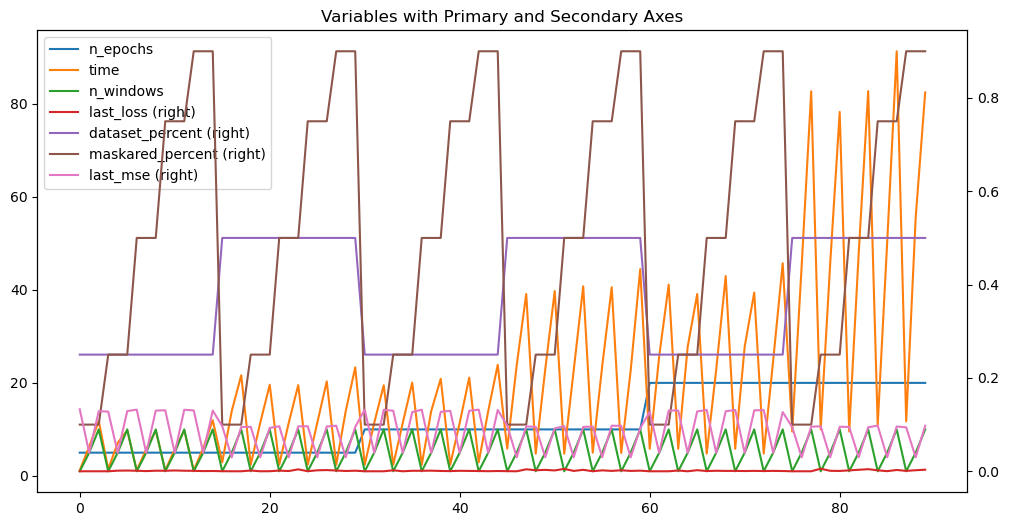

In [157]:
plot_with_multiple_secondary_y(df_time_analysis_base, ["n_epochs", "time", "n_windows"], ["last_loss", "dataset_percent", "maskared_percent", "last_mse"])

In [158]:
profile_base_df = df_time_analysis_base.copy(deep = True)
profile_base = ydp.ProfileReport(profile_base_df, title="Pandas Profiling Report for 'df_time_analysis_base'", explorative=True)

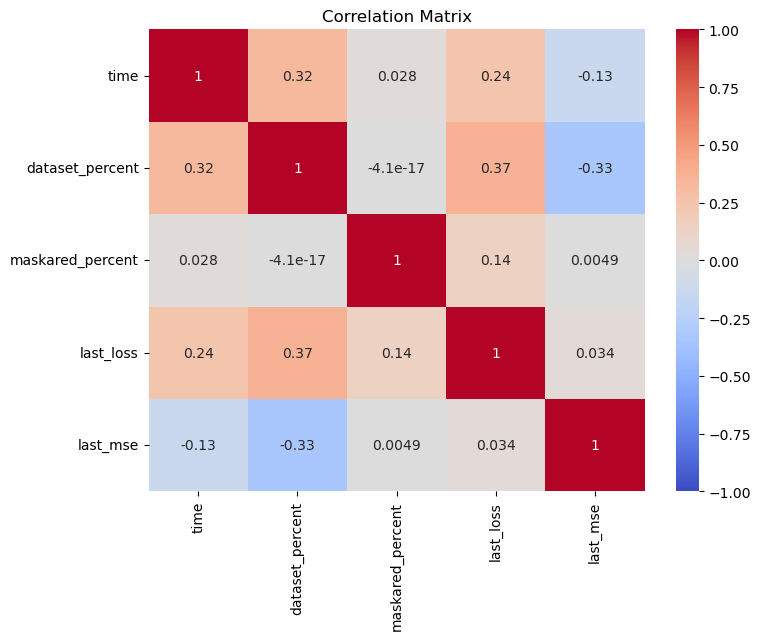

In [159]:
plot_correlation(profile_base_df)

#### Loss & metrics analysis

<Axes: >

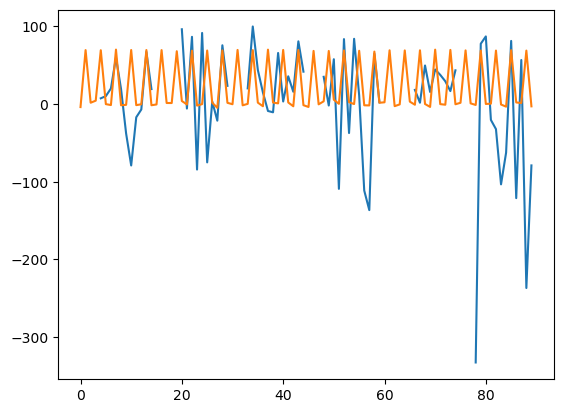

In [160]:
df_loss_base = results_base[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "first_loss", "last_loss", "first_mse", "last_mse"]].copy()
df_loss_base["loss_percent"] = (df_loss_base['first_loss']-df_loss_base['last_loss'])*100/(df_loss_base['first_loss'])
df_loss_base["loss_percent"].plot()
df_loss_base["mse_percent"] = (df_loss_base['first_mse']-df_loss_base['last_mse'])*100/(df_loss_base['first_mse'])
df_loss_base["mse_percent"].plot()

<Axes: >

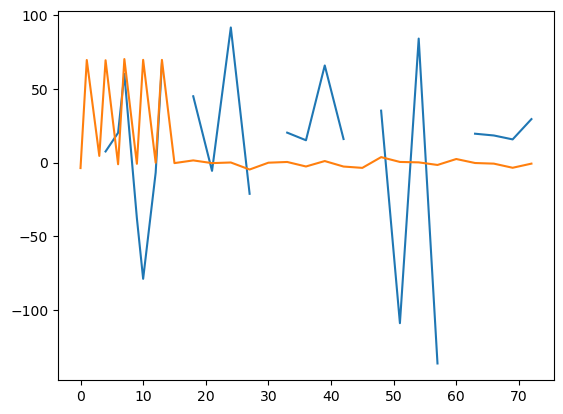

In [161]:
df_loss_base[df_loss_base["time"] < 8]["loss_percent"].plot()
df_loss_base[df_loss_base["time"] < 8]["mse_percent"].plot()

In [162]:
df_loss_base[df_loss_base["time"] < 20]

time n_epochs  dataset_percent  maskared_percent n_windows  \
0    1.220545        5             0.25              0.10         1   
1    6.313306        5             0.25              0.10         5   
2   11.798294        5             0.25              0.10        10   
3    1.469084        5             0.25              0.25         1   
4    7.134445        5             0.25              0.25         5   
5    9.785294        5             0.25              0.25        10   
6    1.199002        5             0.25              0.50         1   
7    5.707859        5             0.25              0.50         5   
8    9.772795        5             0.25              0.50        10   
9    1.198076        5             0.25              0.75         1   
10   5.718150        5             0.25              0.75         5   
11   9.780543        5             0.25              0.75        10   
12   1.198226        5             0.25              0.90         1   
13   5.984858        5             0.25              0.90         5   
14  11.971464        5             0.25              0.90        10   
15   2.927822        5             0.50              0.10         1   
16  13.944155        5             0.50              0.10         5   
18   2.411039        5             0.50              0.25         1   
19  11.426313        5             0.50              0.25         5   
20  19.607974        5             0.50              0.25        10   
21   2.409732        5             0.50              0.50         1   
22  11.404270        5             0.50              0.50         5   
23  19.518115        5             0.50              0.50        10   
24   2.403724        5             0.50              0.75         1   
25  11.389287        5             0.50              0.75         5   
27   2.383326        5             0.50              0.90         1   
28  13.927880        5             0.50              0.90         5   
30   2.401641       10             0.25              0.10         1   
31  11.396286       10             0.25              0.10         5   
32  19.490067       10             0.25              0.10        10   
33   2.384323       10             0.25              0.25         1   
34  11.363173       10             0.25              0.25         5   
36   2.396261       10             0.25              0.50         1   
37  13.942159       10             0.25              0.50         5   
39   2.401967       10             0.25              0.75         1   
40  11.436421       10             0.25              0.75         5   
42   2.922329       10             0.25              0.90         1   
43  13.945674       10             0.25              0.90         5   
45   5.863632       10             0.50              0.10         1   
48   4.790483       10             0.50              0.25         1   
51   4.781079       10             0.50              0.50         1   
54   4.989649       10             0.50              0.75         1   
57   4.935144       10             0.50              0.90         1   
60   5.838694       20             0.25              0.10         1   
63   5.835144       20             0.25              0.25         1   
66   4.802608       20             0.25              0.50         1   
69   5.835138       20             0.25              0.75         1   
72   4.797108       20             0.25              0.90         1   
75   9.533573       20             0.50              0.10         1   
78  10.018001       20             0.50              0.25         1   
81   9.557900       20             0.50              0.50         1   
84  11.002141       20             0.50              0.75         1   
87  11.715304       20             0.50              0.90         1   

    first_loss  last_loss  first_mse  last_mse  loss_percent  mse_percent  
0     0.000000   0.000000   0.128058  0.132865           NaN    -3.754018  
1     0.000000   0.000

In [163]:
# Filtrar filas donde "time" es menor a 8 segundos
df_loss_base_best_cases = df_loss_base[df_loss_base["time"] < 8].copy()

print("---- Mejoras en el entrenamiento ----")
# Filtrar los 5 mejores loss_percents
display(df_loss_base_best_cases.sort_values('loss_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_base_best_cases[df_loss_base_best_cases['dataset_percent'] < 0.50].sort_values('loss_percent', ascending = False)[:5])
print("---- Mejoras en la validación  ----")
# Filtrar los 5 mejores loss_percents
display(df_loss_base_best_cases.sort_values('mse_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_base_best_cases[df_loss_base_best_cases['dataset_percent'] < 0.50].sort_values('mse_percent', ascending = False)[:5])

---- Mejoras en el entrenamiento ----


time n_epochs  dataset_percent  maskared_percent n_windows  \
24  2.403724        5             0.50              0.75         1   
54  4.989649       10             0.50              0.75         1   
13  5.984858        5             0.25              0.90         5   
39  2.401967       10             0.25              0.75         1   
7   5.707859        5             0.25              0.50         5   

    first_loss  last_loss  first_mse  last_mse  loss_percent  mse_percent  
24    0.001861   0.000155   0.096513  0.096483     91.670869     0.031226  
54    0.000597   0.000095   0.095783  0.095676     84.138719     0.111377  
13    0.001215   0.000398   0.129798  0.039373     67.269643    69.666218  
39    0.001198   0.000409   0.130957  0.129645     65.882182     1.001930  
7     0.000961   0.000383   0.132263  0.039373     60.127353    70.231545

time n_epochs  dataset_percent  maskared_percent n_windows  \
13  5.984858        5             0.25              0.90         5   
39  2.401967       10             0.25              0.75         1   
7   5.707859        5             0.25              0.50         5   
72  4.797108       20             0.25              0.90         1   
33  2.384323       10             0.25              0.25         1   

    first_loss  last_loss  first_mse  last_mse  loss_percent  mse_percent  
13    0.001215   0.000398   0.129798  0.039373     67.269643    69.666218  
39    0.001198   0.000409   0.130957  0.129645     65.882182     1.001930  
7     0.000961   0.000383   0.132263  0.039373     60.127353    70.231545  
72    0.000781   0.000551   0.130156  0.131130     29.478824    -0.747931  
33    0.002620   0.002088   0.130273  0.129781     20.284945     0.377997

---- Mejoras en la validación  ----


time n_epochs  dataset_percent  maskared_percent n_windows  \
7   5.707859        5             0.25              0.50         5   
10  5.718150        5             0.25              0.75         5   
13  5.984858        5             0.25              0.90         5   
1   6.313306        5             0.25              0.10         5   
4   7.134445        5             0.25              0.25         5   

    first_loss  last_loss  first_mse  last_mse  loss_percent  mse_percent  
7     0.000961   0.000383   0.132263  0.039373     60.127353    70.231545  
10    0.000967   0.001729   0.129936  0.039373    -78.934245    69.698507  
13    0.001215   0.000398   0.129798  0.039373     67.269643    69.666218  
1     0.000000   0.000000   0.129455  0.039373           NaN    69.585876  
4     0.001414   0.001308   0.128787  0.039373      7.507893    69.428114

time n_epochs  dataset_percent  maskared_percent n_windows  \
7   5.707859        5             0.25              0.50         5   
10  5.718150        5             0.25              0.75         5   
13  5.984858        5             0.25              0.90         5   
1   6.313306        5             0.25              0.10         5   
4   7.134445        5             0.25              0.25         5   

    first_loss  last_loss  first_mse  last_mse  loss_percent  mse_percent  
7     0.000961   0.000383   0.132263  0.039373     60.127353    70.231545  
10    0.000967   0.001729   0.129936  0.039373    -78.934245    69.698507  
13    0.001215   0.000398   0.129798  0.039373     67.269643    69.666218  
1     0.000000   0.000000   0.129455  0.039373           NaN    69.585876  
4     0.001414   0.001308   0.128787  0.039373      7.507893    69.428114

In [164]:
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

20506565120
20506565120


## Moment-large

### Download de large model

In [94]:
print("Getting large artifact: ", enc_artifact_large_name)
enc_artifact_large = wandb_api.artifact(enc_artifact_large_name, type='learner')
print(enc_artifact_large.name)
moment_large = enc_artifact_large.to_obj()

Getting large artifact:  mi-santamaria/deepvats/zeroshot-moment-large-embedding:v0
zeroshot-moment-large-embedding:v0


wandb: Downloading large artifact zeroshot-moment-large-embedding:v0, 1321.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.9


In [96]:
print(count_parameters(moment_large))

341248520


In [ ]:
torch.cuda.memory_allocated()

In [97]:
n_epochs_list     = [5, 10]
dataset_percents  = [0.25, 0.5] # No tendría sentido porque sería como hacer lo mismo que con mvp
maskared_percents = [0.25, 0.5]
sizes             = [1, 5]
print(f"Total cases: {len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)}")

Total cases: 16


In [98]:
torch.cuda.memory_allocated()
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [ ]:
results_large, errors_large = cases_loop(
    model             = moment_large, 
    n_epochs_list     = n_epochs_list,
    dataset_percents  = dataset_percents, 
    maskared_percents = maskared_percents, 
    n_sizes_list      = sizes, 
    summarized        = True
)
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_large)}")
display(errors_large.head())
print(f"Total results: {len(results_large)}")
display(results_large.head())
print("------------------")

In [ ]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_large)}")
display(errors_large.head())
print(f"Total results: {len(results_large)}")
display(results_large.head())

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
enc_learner_large.to('cpu')
for param in enc_learner_large.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
gc.collect()
print("Mejorado: ", after-before)

#### Errors analysis

In [ ]:
error_large_window_sizes = list(errors_large['window'].drop_duplicates())
error_large_window_sizes

In [ ]:
try:
    error_large_mssg = errors_large['error'].astype(str).drop_duplcates()
    display(error_large_mssg)
except Exception as e:
    print(e)

In [ ]:
large_windows = results_large['windows'].drop_duplicates()
print(large_windows.shape)
display(large_windows)

In [ ]:
filtered_windows_large = large_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
display(filtered_windows_large)

#### Time analysis

In [ ]:
df_time_analysis_large = results_large[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "last_loss"]]
df_time_analysis_large.plot(figsize = (10,4))

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_large, ["n_epochs", "time", "n_windows"], ["last_loss", "dataset_percent", "maskared_percent"])

In [ ]:
profile_large_df = df_time_analysis_large.copy(deep = True)
profile_large = ydp.ProfileReport(profile_large_df, title = "Pandas Profiling Report for 'df_time_analysis_large'", explorative = True)
#profile_large.to_notebook_iframe()

In [ ]:
plot_correlation(profile_large_df)

In [ ]:
df_loss_large = results_large[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "first_loss", "last_loss"]].copy()

In [ ]:
df_loss_large["loss_percent"] = (df_loss_large['first_loss']-df_loss_large['last_loss'])*100/(df_loss_large['first_loss'])
df_loss_large["loss_percent"].plot()

In [ ]:
df_loss_large_best_cases = df_loss_large[df_loss_large["time"] < 8].copy()
df_loss_large_beset_cases = df_loss_large_best_cases[df_loss_large_best_cases["loss_percent"] > 0]
print(df_loss_large_best_cases.shape)
display(df_loss_large_best_cases)

In [ ]:
display(df_loss_large_best_cases.sort_values('loss_percent'))

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
gc.collect()
torch.cuda.empty_cache()
after = torch.cuda.memory_allocated()
print(after)
print(after-before)

In [ ]:
gpu_tensors = []
for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_cuda:
            gpu_tensors.append(obj)
    except ReferenceError:
        continue # Omitir los objetos que ya han sido recolectados
print(len(gpu_tensors))

#### Loss & metrics analysis

In [ ]:
#| export
if verbose > 0: print("Execution ended")
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [ ]:
#| hide
if reset_kernel:
    os._exit(00)

# Memory checks

In [ ]:
snapshot = torch.cuda.memory_snapshot()
gpu_tensors = [obj['tensor'] for obj in snapshot if 'tensor' in obj]
for tensor_info in gpu_tensors:
    print(f"Size: {tensor_info['size']}, Device: {tensor_info['device']}, Data type: {tensor_info['dtype']}")
print(gpu_tensors)

In [ ]:
object_types = set()
for obj in snapshot:
    for key in obj.keys():
        object_types.add(key)
print("Tipos de objetos encontrados en el snapshot:")
for obj_type in sorted(object_types):
    print(obj_type)
heavier_obj = None
for obj in snapshot:
    if heavier_obj is None or obj['total_size'] > heavier_obj['total_size']: heavier_obj = obj
print(heavier_obj)

In [ ]:
before = torch.cuda.memory_allocated()
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
enc_learner_small.to('cpu')
for param in enc_learner_small.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
enc_learner_base.to('cpu')
for param in enc_learner_base.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
enc_learner_large.to('cpu')
for param in enc_learner_large.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
results_small.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)